In [1]:
import os
import random

import pandas as pd
import numpy as np
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import _gradient_boosting
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
# from helper_functions_pipe_testing import *
from sklearn.metrics import  f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# from imblearn.over_sampling import *
from sklearn.preprocessing import LabelEncoder
from helper_functions_KP import *
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
import math

#Instructions for the pipeline Requires two inputs for training: - Mass spec data with corresponding NP surface characteristics and experimental conditions (time, concentration) - NetsurfP and Biopython data that has been precalculated - X characteristics to predict
pipeline Take mass spec spreadsheet Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration Merge with Proteome data to get file that has Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration,Mass,Length,Sequence Calculate protein features using biopython Merge with NSP data to get all protein features
Split into X and Y dataset with Entries as labels
In this pipeline (look at synth dataset and generate validation and prediction datasets out of original dataset)

In [8]:
#Sample code for loading saved DF and dropping appropriate columns before running### Also For running RFECV and saving the reduced df
df_filepath='Input_data/Save_files/df_2_Synth.xlsx'
id='04232023'
df = pd.read_excel(df_filepath, header=0)
to_drop = df.filter(like='total_exposed_')
df=df.drop(columns=to_drop.columns).copy()
df.to_excel("Input_data/Save_files/df_2_Synth.xlsx")
# labels_df= df['Abundance'].copy()
# id_col= df['NPUNID'].copy()
# label_abund=np.ravel(labels_df)
# model=RandomForestRegressor(n_estimators=100)
# splits=10
# scoring='neg_mean_squared_error'
# df=df.drop(columns=['Entry', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID'])
# import math
#
# start = 0.0001
# stop = 1
# num_points = 10
# # Calculate the common difference between consecutive terms in the series
# common_diff = (math.log(stop) - math.log(start)) / (num_points - 1)
# # Generate the logarithmic series as a list
# Abund_filter = [start * math.exp(i * common_diff) for i in range(num_points)]
# # model = RandomForestRegressor(n_estimators=80)
# # summary_tmp=[]
# for i in Abund_filter:
#     df_out= df[df['Abundance']>=i].copy()
# df = RFECV_plot(df,label_abund,model,id,folds=splits,step=2,scoring=scoring)

    # df_out.to_excel("Input_data/Save_files/Abund_Filters/df_1_all"+str(i)+".xlsx")


In [ ]:
#Tests to perform#
##For RFR and RFC##
#RFECV control abundance and no control abundance
#RFE Curve -> performance curve relative to number of features selected#



In [2]:
##Run RFECV on synth database to see what features it sees as important and how many are important- Vary scoring methods##
in_dir='Input_data/Save_files/df_2_Synth.xlsx'

df = pd.read_excel(in_dir, header=0)
model=RandomForestRegressor(n_estimators=100)
#Drop zero values#
Min_Control=df['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]

# df_filepath='Input_data/Save_files/df_1_all.xlsx'
ids=['r2','neg_mean_squared_error','explained_variance']
summary_tmp=[]
feats=[]
for identifier in ids:
    print(identifier)
    df = pd.read_excel(in_dir, header=0)
    df=df[df['Abundance']>=Min_Control]
    labels_df= df['Abundance'].copy()
    id_col= df['NPUNID'].copy()
    label_abund=np.ravel(labels_df)
    label_abund=np.log2(label_abund)
    # df=df.drop(columns=['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID','NPUNID','Abundance_Controls'])
    # df=df.drop(columns=['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID','NPUNID'])
    if identifier=='NoCA':
        df=df.drop(columns='Abundance_Controls')
    df=df.drop(columns=['Abundance','NPUNID','NPID','Entry','Sequence','Sample_num', 'Raw_FileID','Ligands'])
    step = 1
    selector = RFE(model, n_features_to_select=75, step=step)
    selector = selector.fit(df, label_abund)
    feat_list = selector.get_feature_names_out()
    df = df[feat_list].copy()


    min_feats = 1
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    selector = RFECV(estimator=model, cv=cv, min_features_to_select=min_feats,
                     step=step,scoring=identifier)
    selector = selector.fit(df, label_abund)
    selector.support_
    feat_list2 = selector.get_feature_names_out()
    selected_features = df.columns[selector.support_]
    df = df[feat_list2]
    # df.to_excel("Input_data/Save_files/df_RFECV"+id+id2+".xlsx")
    rfecv_df=pd.DataFrame(selector.cv_results_)
    rfecv_df.to_excel("Output_data/RFECV_resultsRFR"+identifier+".xlsx",index=False)
    df=RFECV_plot(df,label_abund,model,identifier,10,1)
    tmp2,tmp3=scorer(df, label_abund, model, identifier=identifier, folds=10)
    summary_tmp.append(tmp2)
    feats.append(tmp3)
# lasso_feature_selection(df, label_abund, id)
summary=pd.concat(summary_tmp,axis=0)
feat_summary=feats[0]
for d in feats[1:]:
    feat_summary=feat_summary.merge(d, on='Features',how='outer')
feat_summary.to_excel('Output_data/Feats_RFECV_log2_synth_RFR.xlsx', index=False)
summary.to_excel('Output_data/Scores_RFECV_log2_synth_RFR.xlsx', index=False)
print('done')


r2
Recursive Feature Elimination with Correlated Features ran successfully
Scorer ran successfully
neg_mean_squared_error
Recursive Feature Elimination with Correlated Features ran successfully
Scorer ran successfully
explained_variance
Recursive Feature Elimination with Correlated Features ran successfully
Scorer ran successfully
done


In [30]:
bl=identifier

In [35]:
folds=5
tmp2,tmp3=scorer(df_a,label_abund,model,ids[0],folds=folds)

TypeError: 'str' object is not callable

In [ ]:
sc

In [11]:
'as'+identifier

'asr2'

In [25]:
##Run RFE to different numbers of features and see how the score changes with each variation # test with and without Control abundance##
in_dir='Input_data/Save_files/df_2_Synth.xlsx'

df = pd.read_excel(in_dir, header=0)
model=RandomForestRegressor(n_estimators=100)
#Drop zero values#
Min_Control=df['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
df=df[df['Abundance']>=Min_Control]
# df_filepath='Input_data/Save_files/df_1_all.xlsx'
featnums=np.arange(75,1,-1).tolist()
ids=['CA','NoCA']
summary_tmp=[]
feats=[]

for identifier in ids:
    df = pd.read_excel(in_dir, header=0)
    df=df[df['Abundance']>=Min_Control]
    if identifier=='NoCA':
        df=df.drop(columns='Abundance_Controls')


    labels_df= df['Abundance'].copy()
    id_col= df['NPUNID'].copy()
    label_abund=np.ravel(labels_df)
    label_abund=np.log2(label_abund)
    df=df.drop(columns=['Abundance','NPUNID','Entry','Sequence','Sample_num', 'Raw_FileID','Ligands','NPID'])
    for n_feats in featnums:
        identity=identifier+str(n_feats)
        step = 1
        selector = RFE(model, n_features_to_select=n_feats, step=step)
        selector = selector.fit(df, label_abund)
        feat_list = selector.get_feature_names_out()
        df = df[feat_list].copy()
        tmp2,tmp3=scorer(df, label_abund, model, identity, 10)
        summary_tmp.append(tmp2)
        feats.append(tmp3)
# lasso_feature_selection(df, label_abund, id)
summary=pd.concat(summary_tmp,axis=0)
feat_summary=feats[0]
for d in feats[1:]:
    feat_summary=feat_summary.merge(d, on='Features',how='outer')
feat_summary.to_excel('Output_data/Feats_RFEs_log2.xlsx', index=False)
summary.to_excel('Output_data/Scores_RFEs_log2.xlsx', index=False)
print('done')

Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran succe

In [4]:
### Running Binary Classification systems and seeing what abund threshold is the best for performance##

abund_thresh=[-2,-1,-0.5,0.25,0.5,0.75,1,2,3,4]
df_filepath='Input_data/Save_files/df_2_Synth.xlsx'
df = pd.read_excel(df_filepath, header=0)
Min_Control=df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
df['Abundance_Controls'].replace(0,Min_Control,inplace=True)
df['Enrich']= np.log2(df['Abundance']/df['Abundance_Controls'])
# df = df.replace(np.inf,10)
model=RandomForestClassifier()
# id='RFR_AFilter_'+str(i)+'NoCon'
# Create an empty pandas DataFrame to store the evaluation metrics
# eval_df = pd.DataFrame(columns=['Abund Thresh', 'F1', 'AUROC', 'Accuracy', 'Precision', 'Recall'])
df=df.drop(columns=['Abundance','Entry','Sequence','Sample_num', 'Raw_FileID','NPID','Ligands'])
# df=df.drop(columns=['Abundance_Controls'])
summary_tmp=[]
feats =[]
# Iterate through multiple iterations of model training and testing
for i in abund_thresh:
    identifier='thresh_CA_'+str(i)
    df_a=df.copy()
    df_a['binary_target']= df_a['Enrich'].apply(lambda t: 1 if t>=i else 0)
    labels_df = df_a['binary_target'].copy()
    # id_col= df_a['NPUNID'].copy()
    label_binary=np.ravel(labels_df)
    df_a=df_a.drop(columns=['NPUNID','binary_target','Enrich']).copy()

    step = 2
    RFE_Feats=20
    selector = RFE(model, n_features_to_select=RFE_Feats, step=step)
    selector = selector.fit(df_a, label_binary)
    selector.support_
    ranking = selector.ranking_
    feat_list = selector.get_feature_names_out()
    df_a = df_a[feat_list].copy()

    # x_train, x_test, y_train, y_test = train_test_split(df_a, label_binary, test_size=0.3, random_state=42)
    # model.fit(x_train, y_train)
    # y_pred = model.predict(x_test)
    # f1 = f1_score(y_test, y_pred)
    # auroc = roc_auc_score(y_test, y_pred)
    # accuracy = accuracy_score(y_test, y_pred)
    # precision = precision_score(y_test, y_pred)
    # recall = recall_score(y_test, y_pred)
    score_tmp, feat_tmp=scorer_RFC(df_a,label_binary,model,identifier,10)
    # Append a new row to the eval_df DataFrame with the evaluation metrics for this iteration
    summary_tmp.append(score_tmp)
    feats.append(feat_tmp)
# lasso_feature_selection(df, label_abund, id)
summary=pd.concat(summary_tmp,axis=0)
feat_summary=feats[0]
for d in feats[1:]:
    feat_summary=feat_summary.merge(d, on='Features',how='outer')
feat_summary.to_excel('Output_data/Feats_RFR_AbundThresh_CA.xlsx', index=False)
summary.to_excel('Output_data/Scores_RFR_AbundThresh_CA.xlsx', index=False)
print('done')
#
#     tmp = pd.DataFrame({'Abund Thresh': i,
#                               'F1': f1,
#                               'AUROC': auroc,
#                               'Accuracy': accuracy,
#                               'Precision': precision,
#                               'Recall': recall}, index=[0])
#
#     eval_df = pd.concat([eval_df,tmp],ignore_index=True,axis=0)
#
# eval_df.to_excel('Output_data/AbundThresholdingRFC2.xlsx', index=False)

C:\Users\pouls\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully


PermissionError: [Errno 13] Permission denied: 'Output_data/Feats_RFR_AbundThresh.xlsx'

In [23]:
##Run RFE to different numbers of features and see how the score changes with each variation # test with and without Control abundance##
in_dir='Input_data/Save_files/df_2_Synth.xlsx'
# df = df.replace(np.inf,10)
model=RandomForestClassifier()
# df_filepath='Input_data/Save_files/df_1_all.xlsx'
# featnums=[75,60,50,40,30,25,20,18,15,12,10,8,5,4,3,2]
featnums=np.arange(75,1,-1).tolist()
ids=['CA','NoCA']
summary_tmp=[]
feats=[]
df_a=df.copy()
thresh=1


for identifier in ids:
    #Drop zero values#
    df = pd.read_excel(in_dir, header=0)
    # Min_Abund=df['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    # df=df[df['Abundance']>=Min_Abund]

    #replace 0s in abundance controls
    Min_Control=df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    df['Abundance_Controls'].replace(0,Min_Control,inplace=True)

    #calculate enrichment and then convert into binary target based on Enrich threshold (thresh)
    df['Enrich']= np.log2(df['Abundance']/df['Abundance_Controls'])
    df['binary_target']= df['Enrich'].apply(lambda t: 1 if t>=thresh else 0)
    if identifier=='NoCA':
        df=df.drop(columns='Abundance_Controls')
    labels_df = df['binary_target'].copy()
    label_abund=np.ravel(labels_df)
    df=df.drop(columns=['Abundance','NPUNID','Entry','Sequence','Sample_num', 'Raw_FileID','Ligands','Enrich','binary_target','NPID'])
    for n_feats in featnums:
        identity=identifier+str(n_feats)
        step = 1
        selector = RFE(model, n_features_to_select=n_feats, step=step)
        selector = selector.fit(df, label_abund)
        feat_list = selector.get_feature_names_out()
        df = df[feat_list].copy()
        tmp2,tmp3=scorer_RFC(df, label_abund, model, identity, 10)
        summary_tmp.append(tmp2)
        feats.append(tmp3)
# lasso_feature_selection(df, label_abund, id)
summary=pd.concat(summary_tmp,axis=0)
feat_summary=feats[0]
for d in feats[1:]:
    feat_summary=feat_summary.merge(d, on='Features',how='outer')
feat_summary.to_excel('Output_data/Feats_RFEs_RFC.xlsx', index=False)
summary.to_excel('Output_data/Scores_RFEs_RFC.xlsx', index=False)
print('done')

C:\Users\pouls\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran succe

C:\Users\pouls\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran succe

In [33]:
##Run RFECV for classification test with and without Control abundance--Classifier, keep control abundance since it is dropped anyways##
in_dir='Input_data/Save_files/df_2_Synth.xlsx'



#Drop zero values#

# df = df.replace(np.inf,10)
model=RandomForestClassifier()
# df_filepath='Input_data/Save_files/df_1_all.xlsx'
# featnums=[75,60,50,40,30,25,20,18,15,12,10,8,5,4,3,2]
featnums=np.arange(75,5,-1).tolist()
ids=['CA']
summary_tmp=[]
feats=[]
df_a=df.copy()
thresh=1


for identifier in ids:
    df = pd.read_excel(in_dir, header=0)
    #drop zeros
    # Min_Control=df['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    # df=df[df['Abundance']>=Min_Control]
    #

    Min_Abund=df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    df['Abundance_Controls'].replace(0,Min_Abund,inplace=True)
    df['Enrich']= np.log2(df['Abundance']/df['Abundance_Controls'])
    df['binary_target']= df['Enrich'].apply(lambda t: 1 if t>=thresh else 0)
    if identifier=='NoCA':
        df=df.drop(columns='Abundance_Controls')
    labels_df = df['binary_target'].copy()
    label_abund=np.ravel(labels_df)
    df=df.drop(columns=['Abundance','NPUNID','Entry','Sequence','Sample_num', 'Raw_FileID','Ligands','Enrich','binary_target','NPID'])

    identity=identifier
    step = 1

    min_feats = 1
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    selector = RFECV(estimator=model, cv=cv, min_features_to_select=min_feats,
                     step=step, scoring='f1')
    selector = selector.fit(df, label_abund)
    selector.support_
    feat_list2 = selector.get_feature_names_out()
    selected_features = df.columns[selector.support_]
    df = df[feat_list2]
    # df.to_excel("Input_data/Save_files/df_RFECV"+id+id2+".xlsx")
    rfecv_df=pd.DataFrame(selector.cv_results_)
    rfecv_df.to_excel("Output_data/RFECV_resultsRFC"+identifier+".xlsx",index=False)
    tmp2,tmp3=scorer_RFC(df, label_abund, model, identity, 10)
    summary_tmp.append(tmp2)
    feats.append(tmp3)
# lasso_feature_selection(df, label_abund, id)
summary=pd.concat(summary_tmp,axis=0)
feat_summary=feats[0]
for d in feats[1:]:
    feat_summary=feat_summary.merge(d, on='Features',how='outer')
feat_summary.to_excel('Output_data/Feats_RFEcv_RFC.xlsx', index=False)
summary.to_excel('Output_data/Scores_RFEcv_RFC.xlsx', index=False)
print('done')

C:\Users\pouls\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scorer ran successfully
done


32
17
25
35
34
21
18
29
26
28
20
24
33
23
27
31
19
30
22


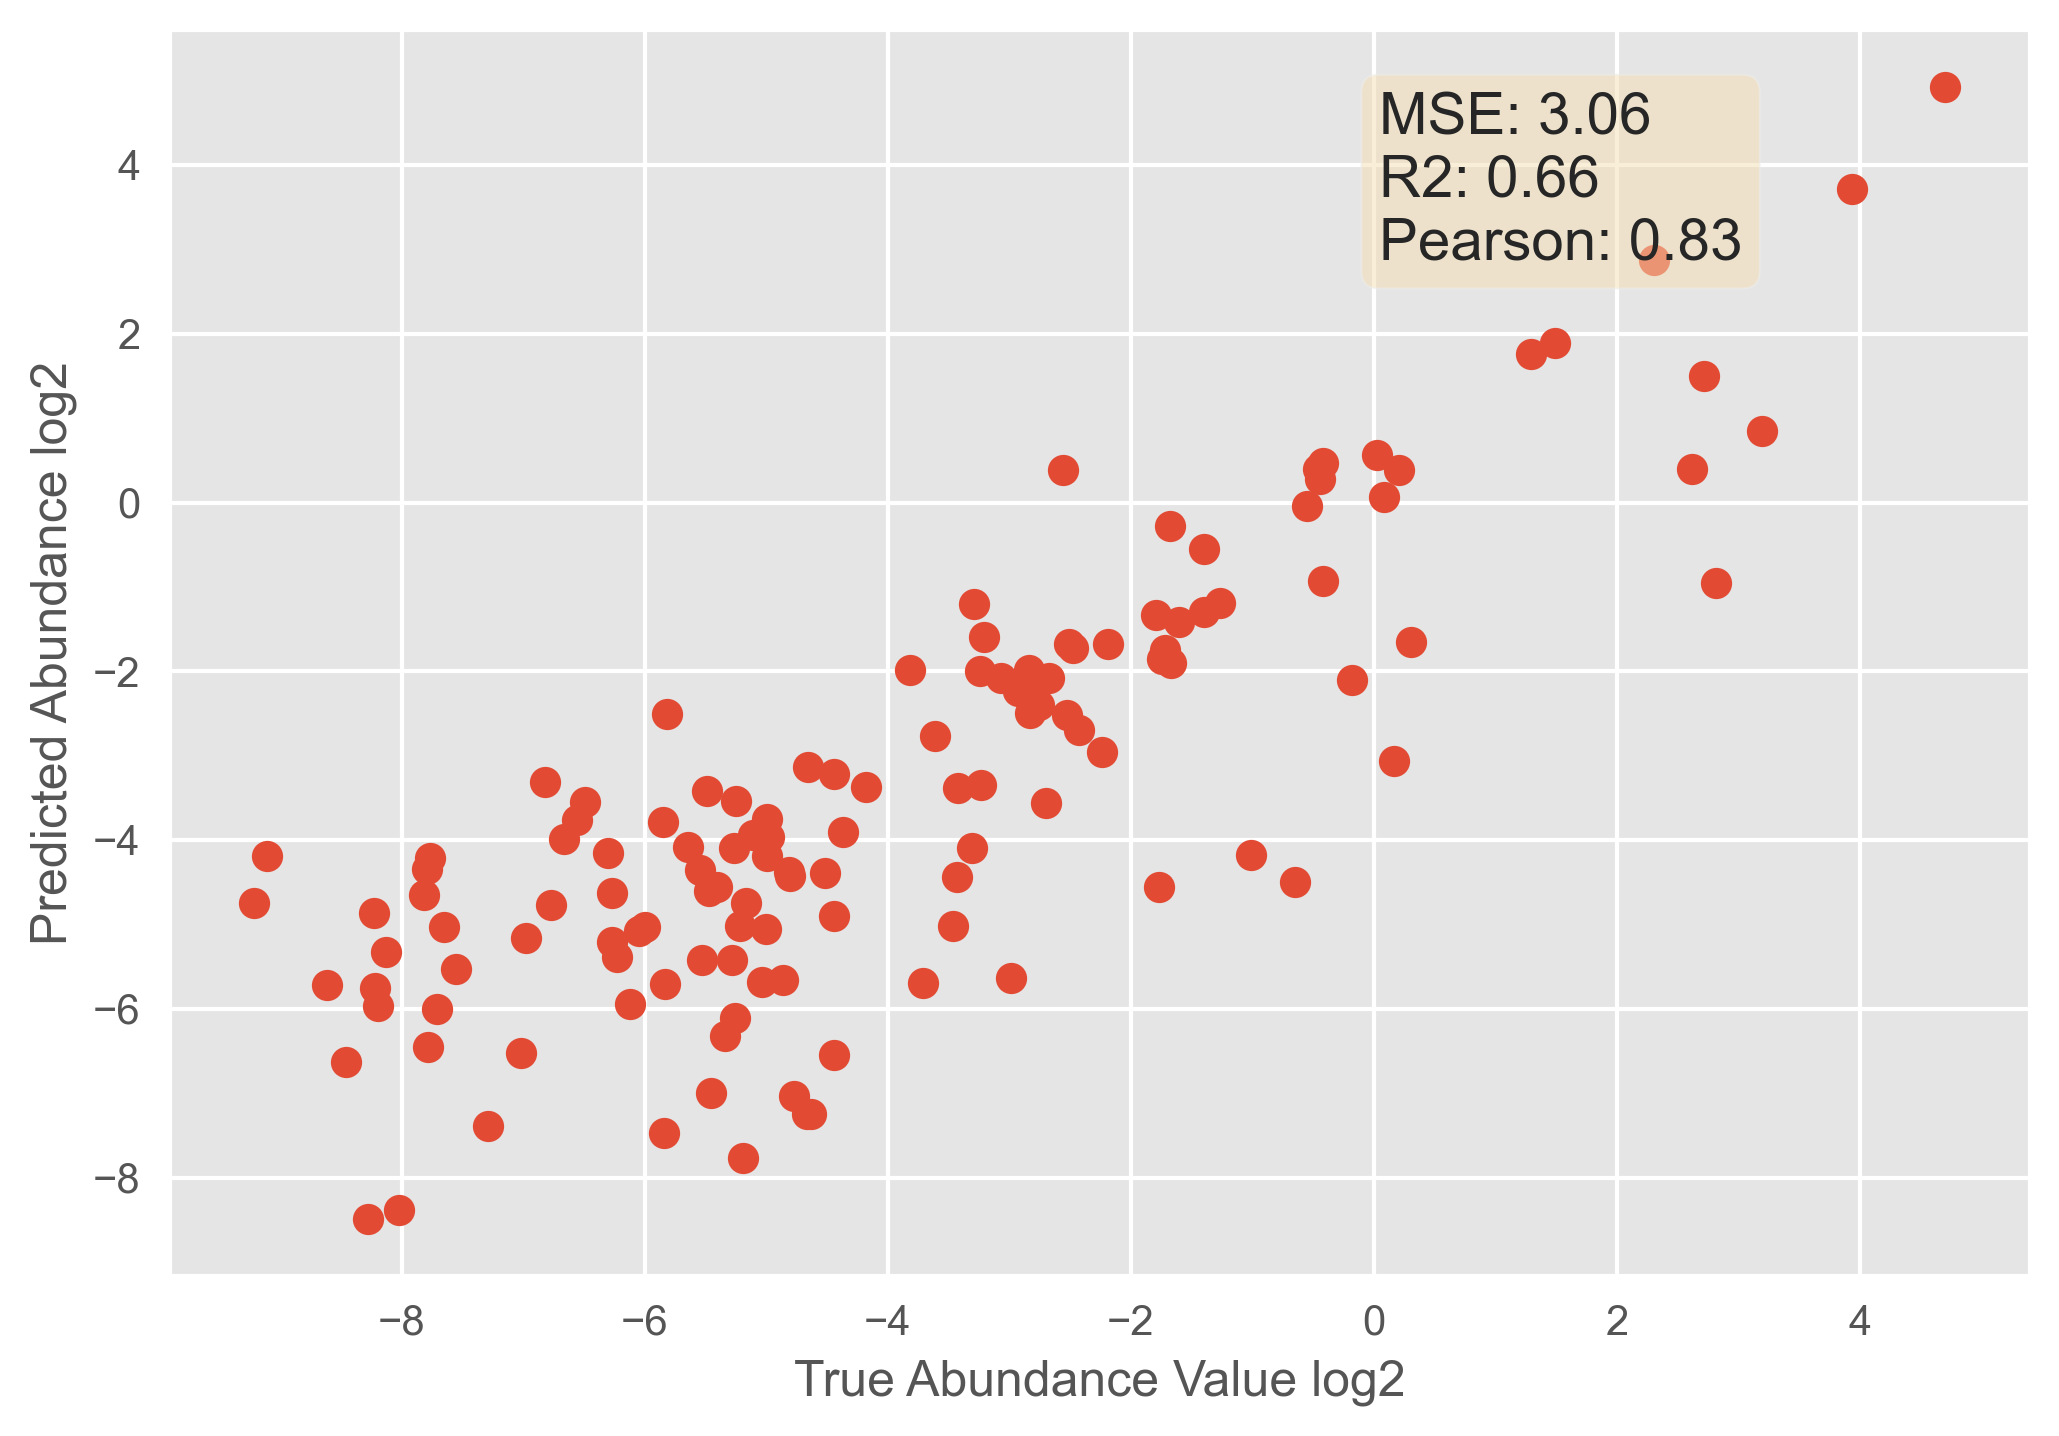

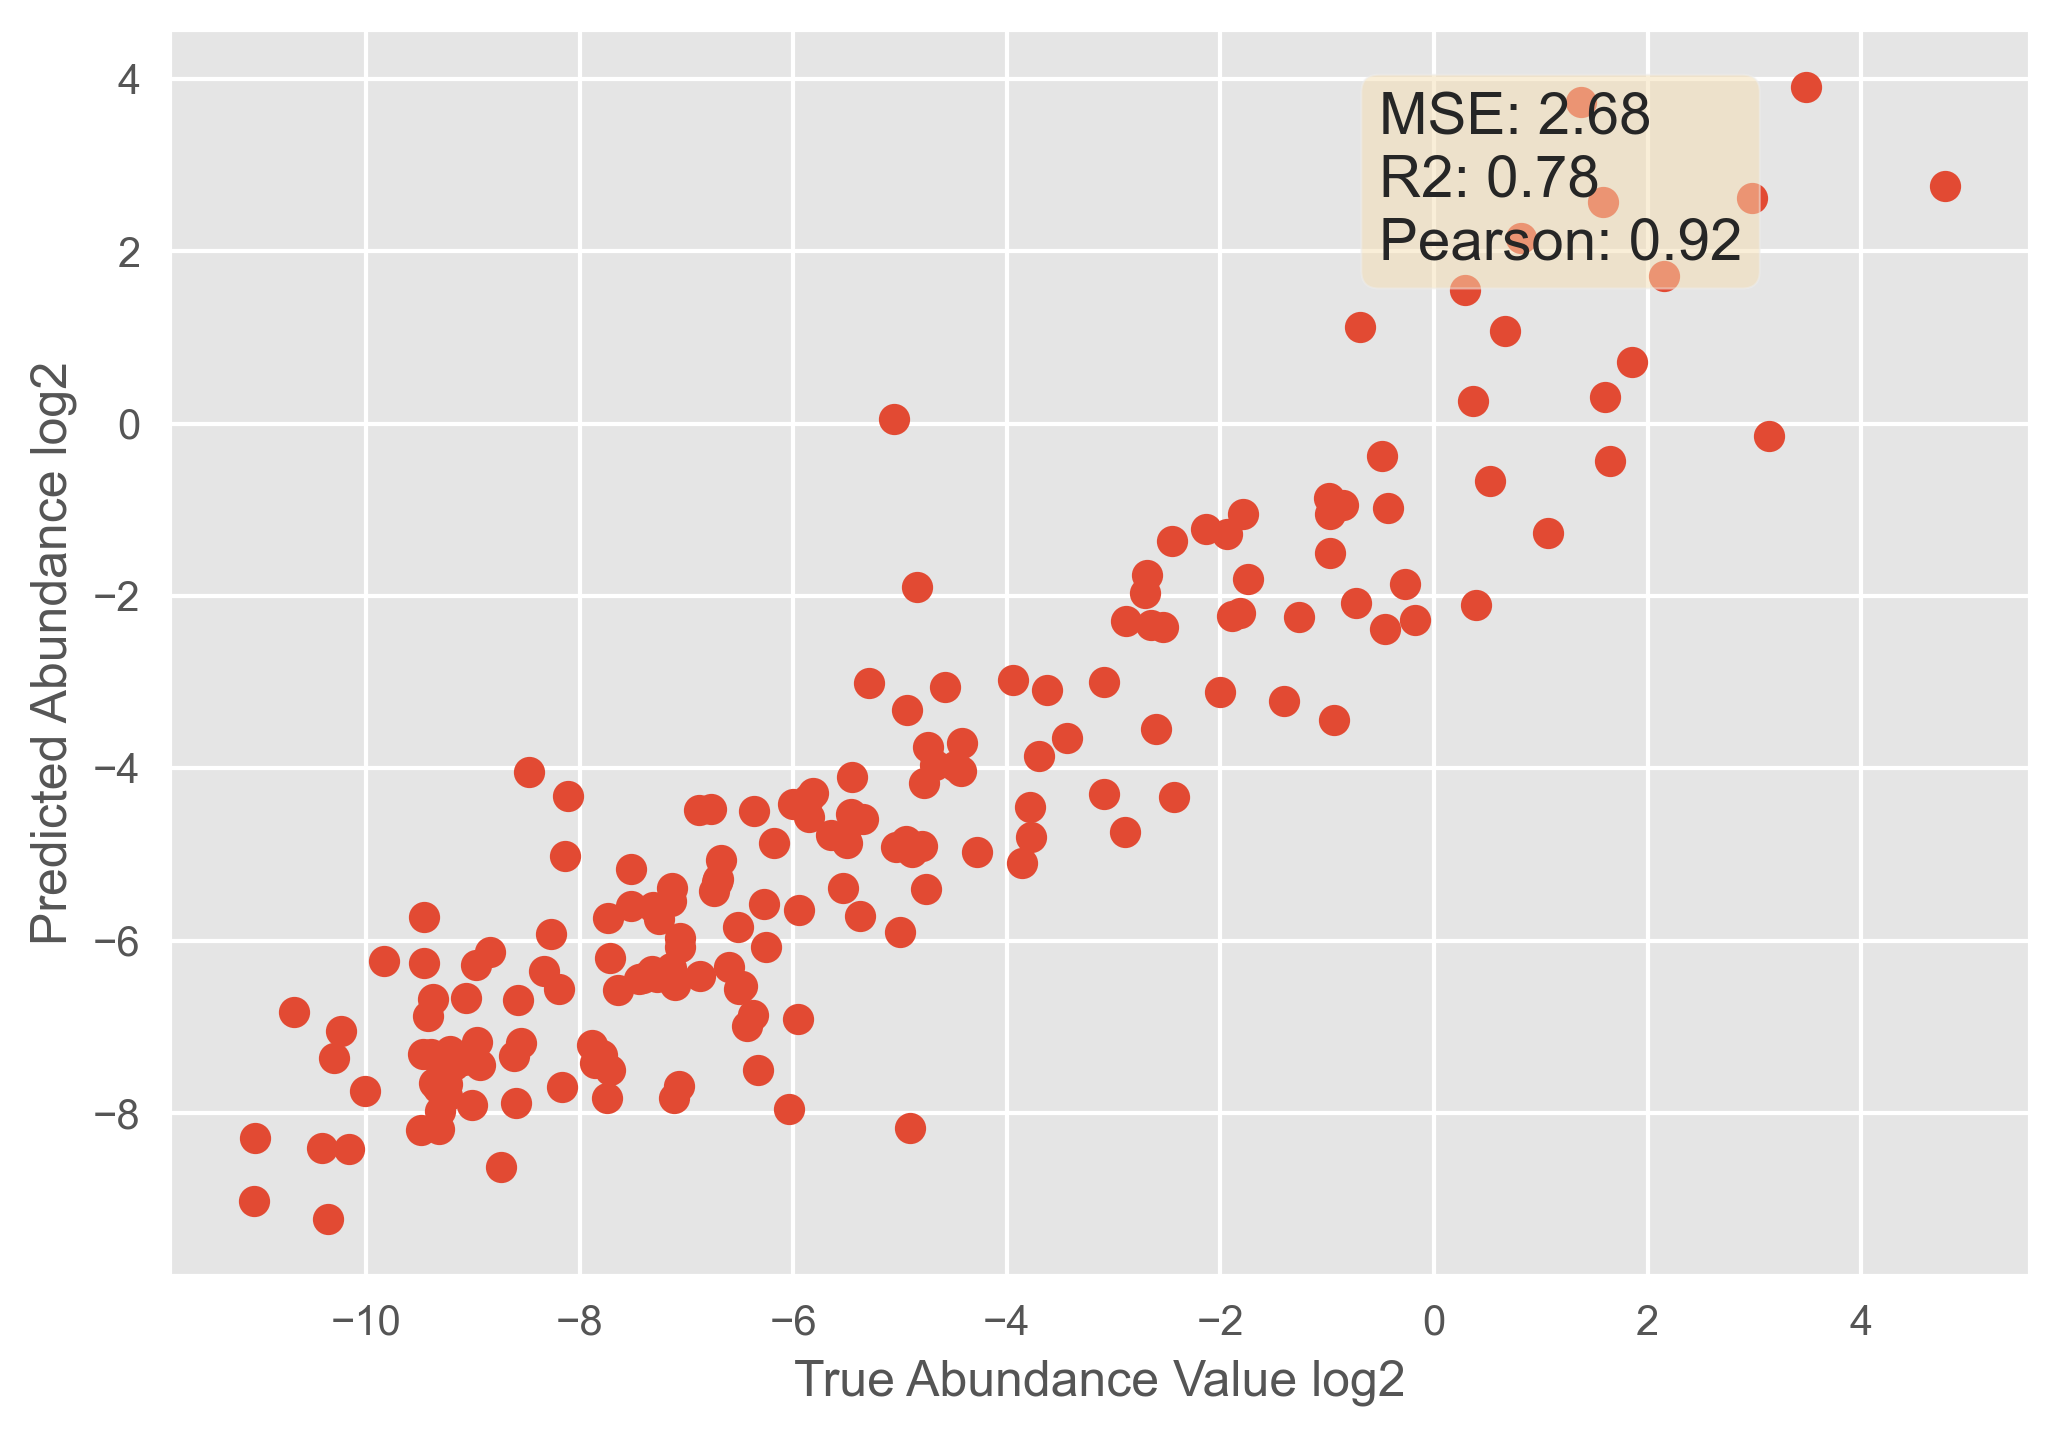

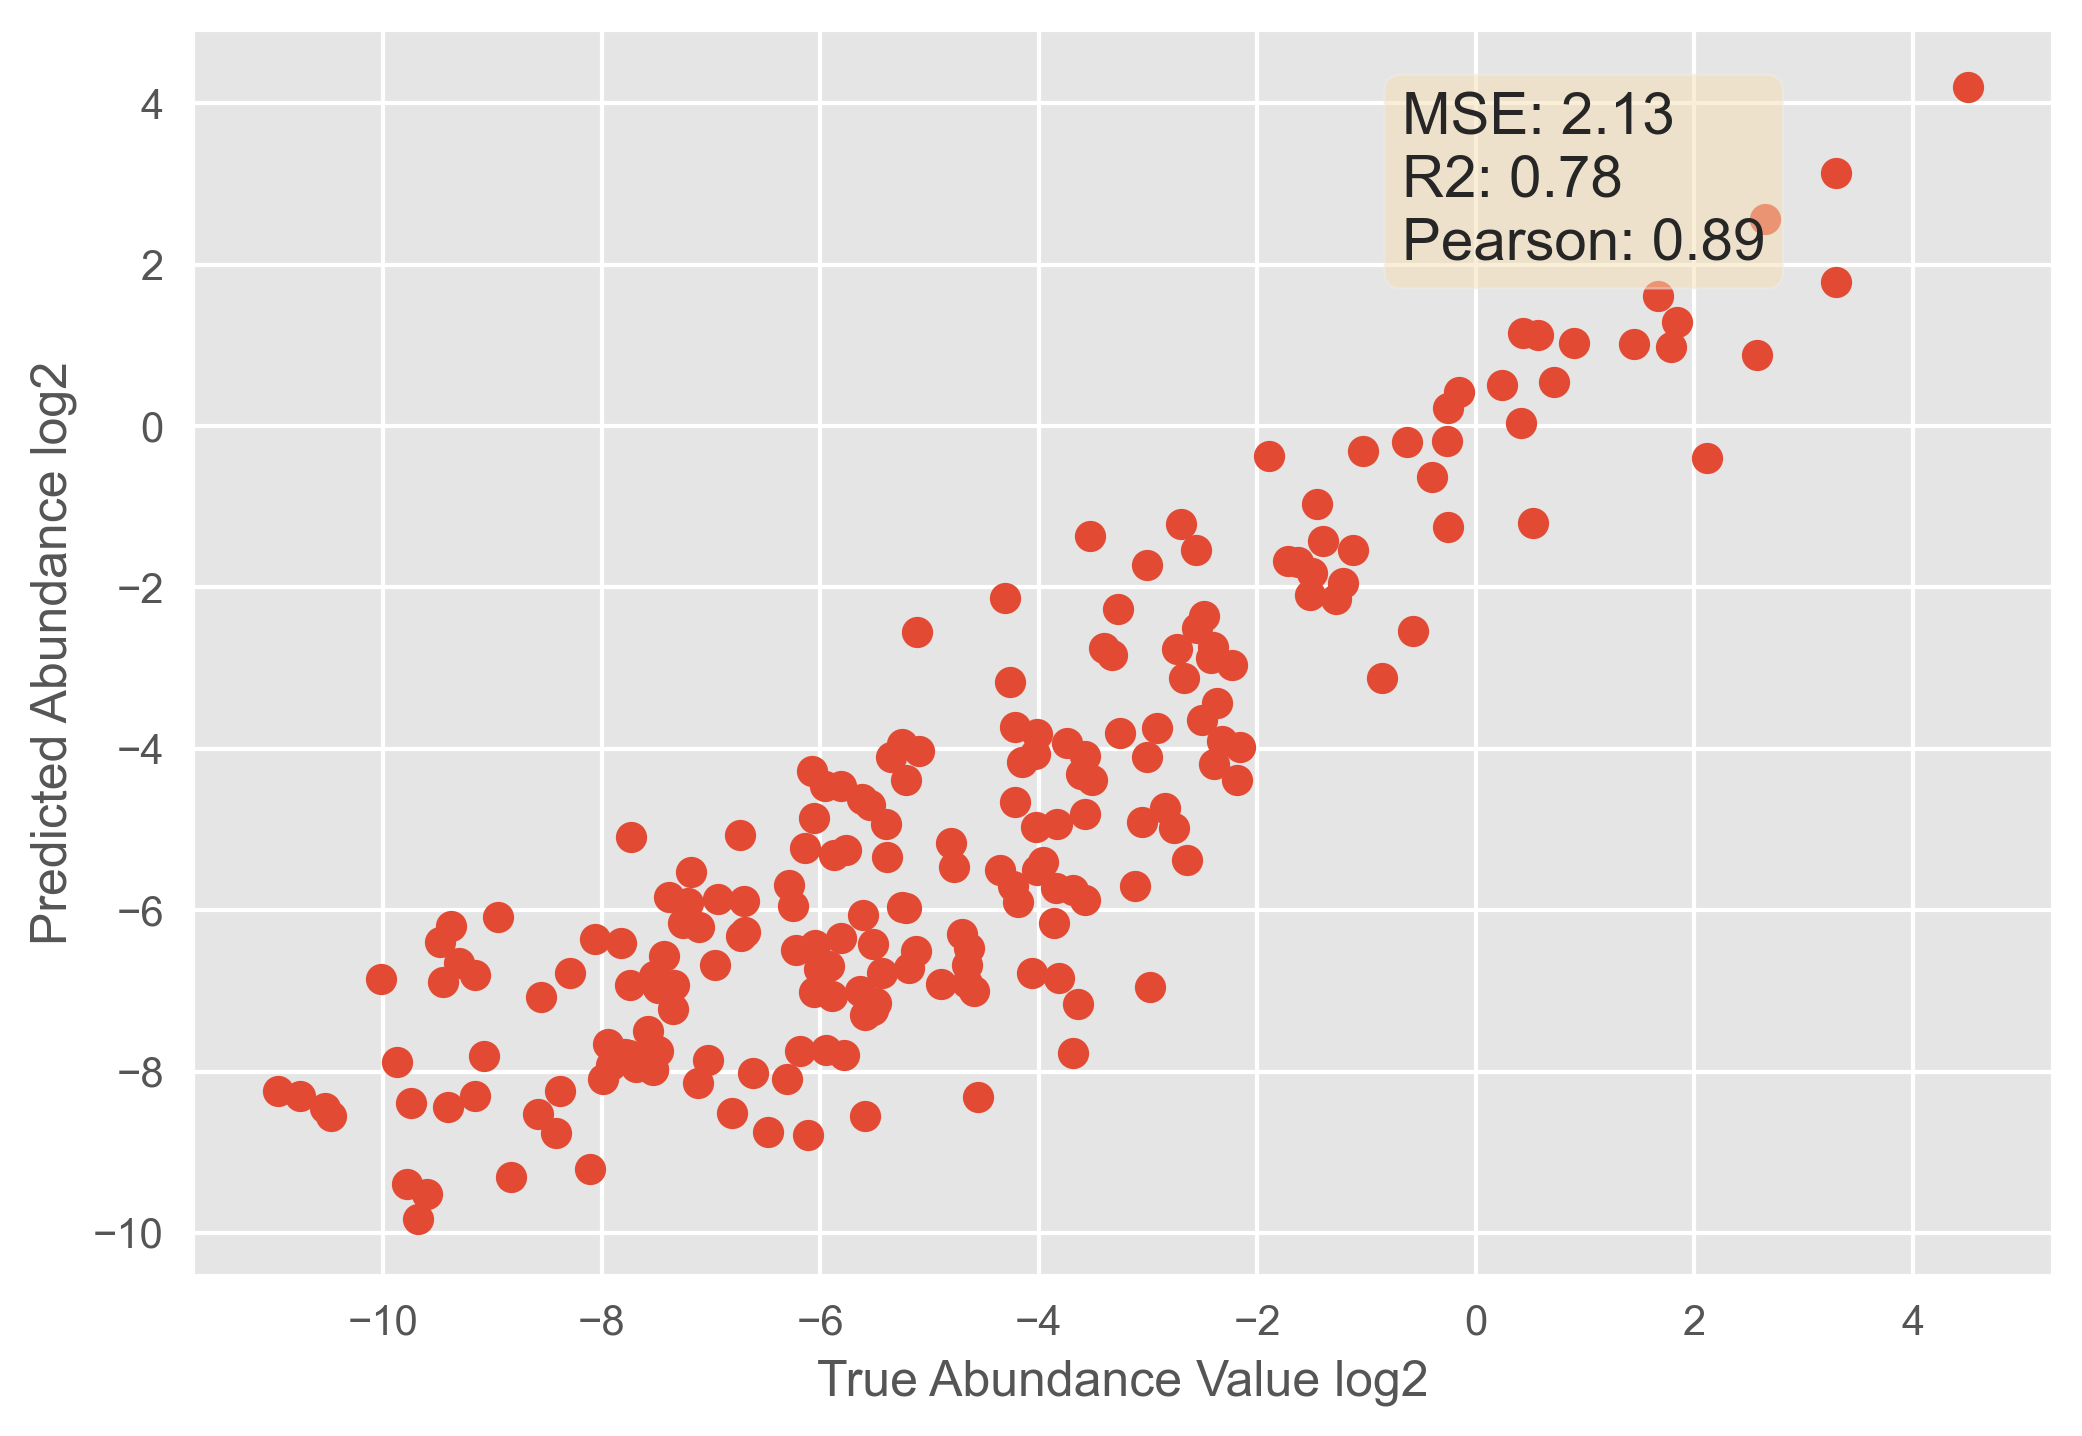

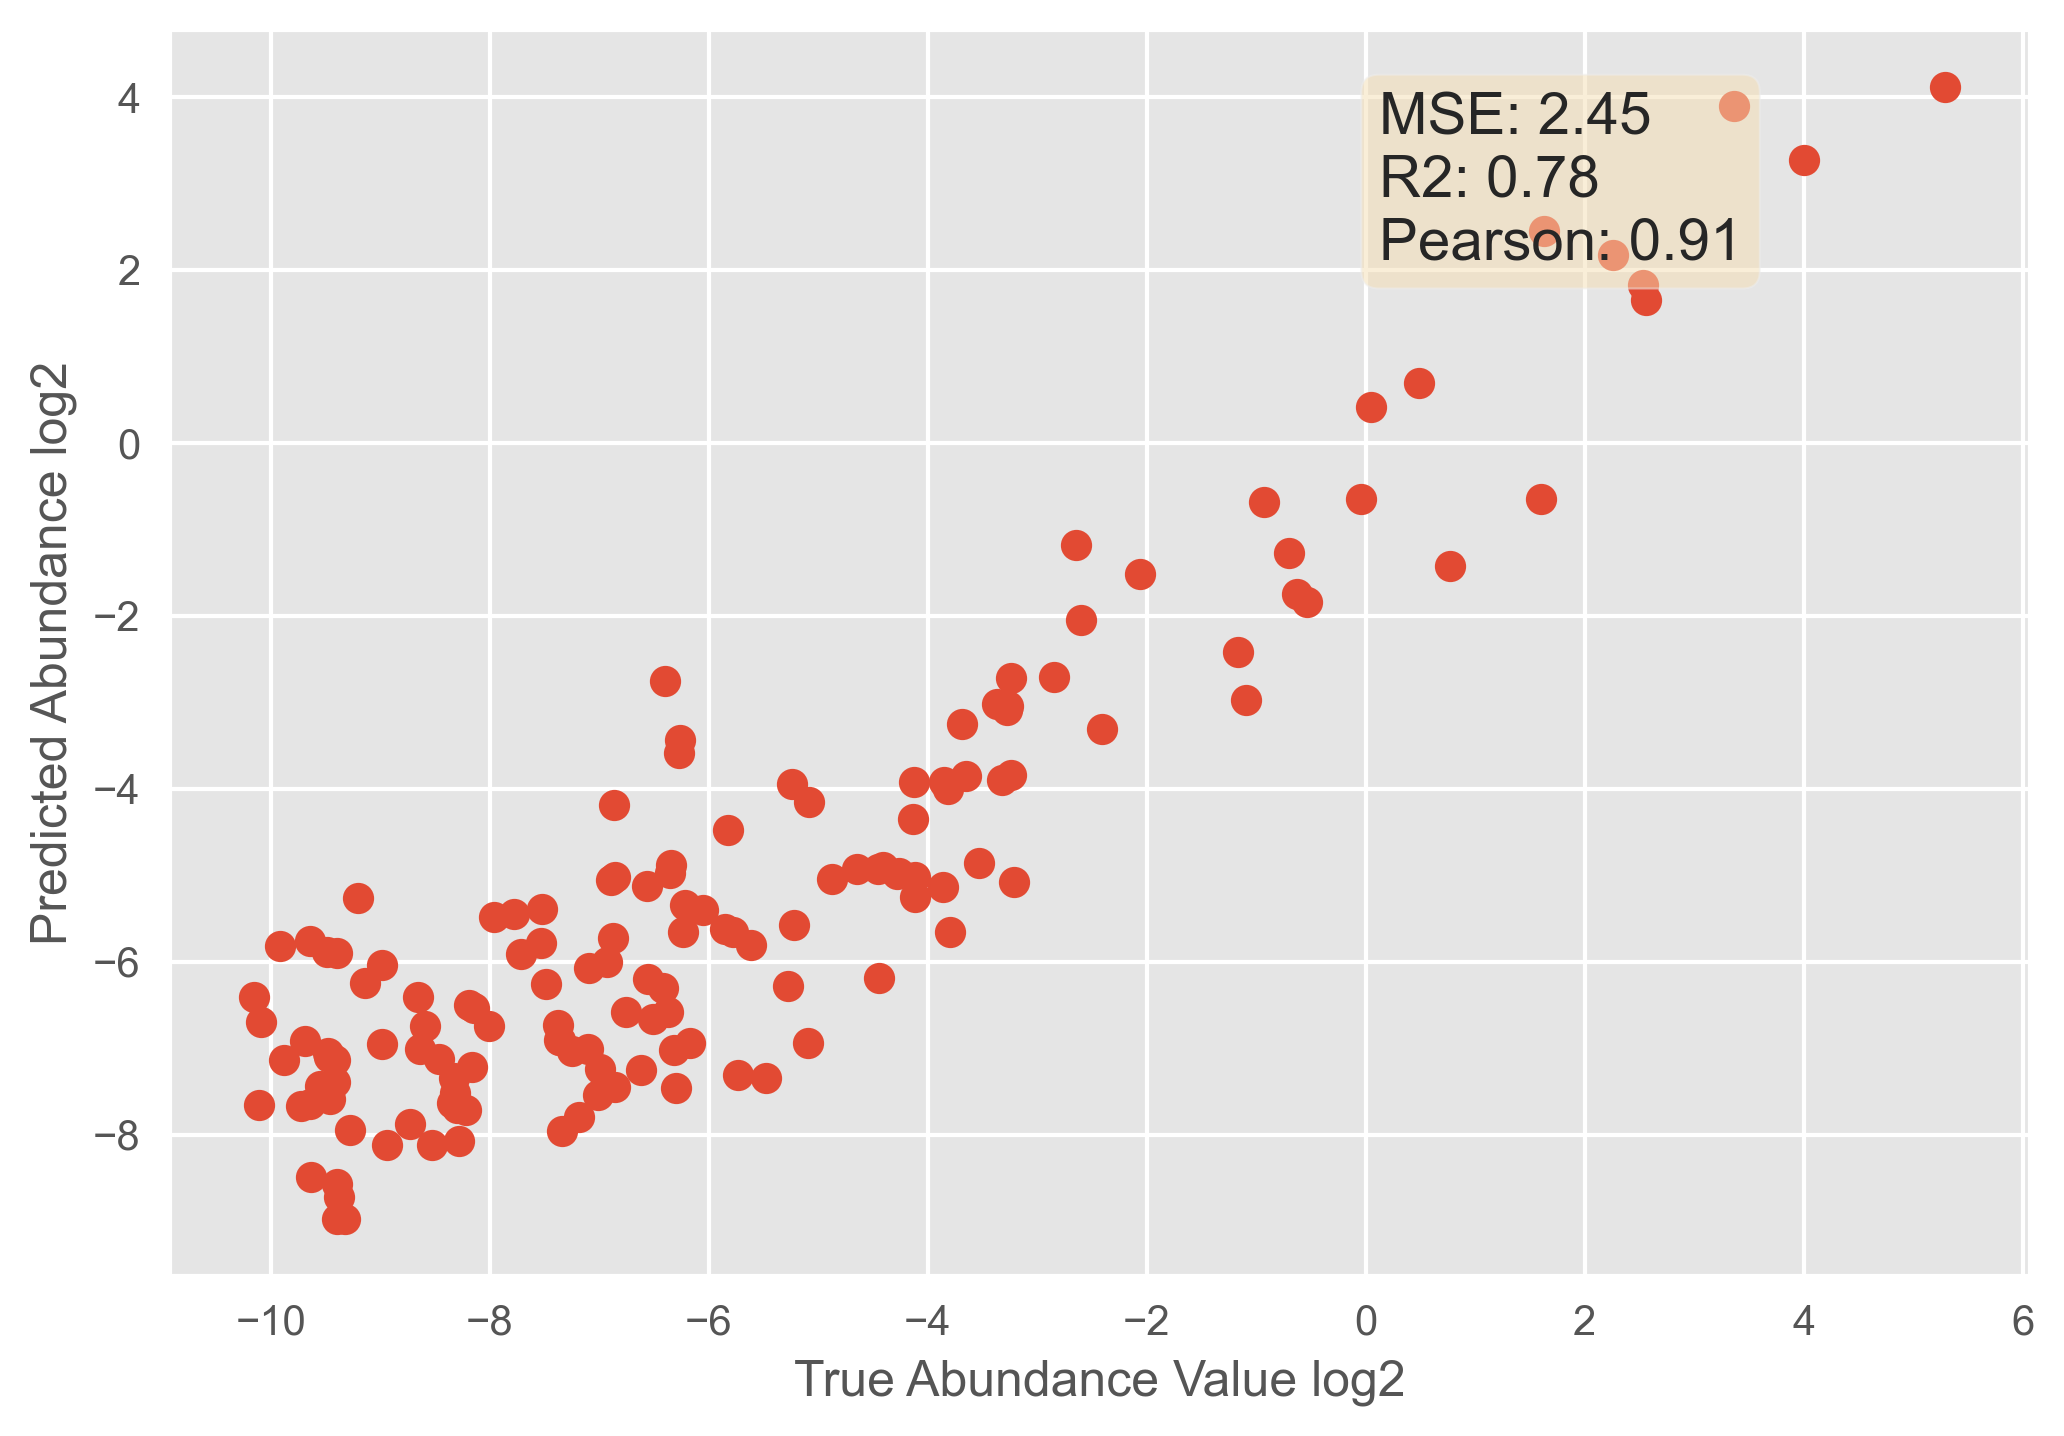

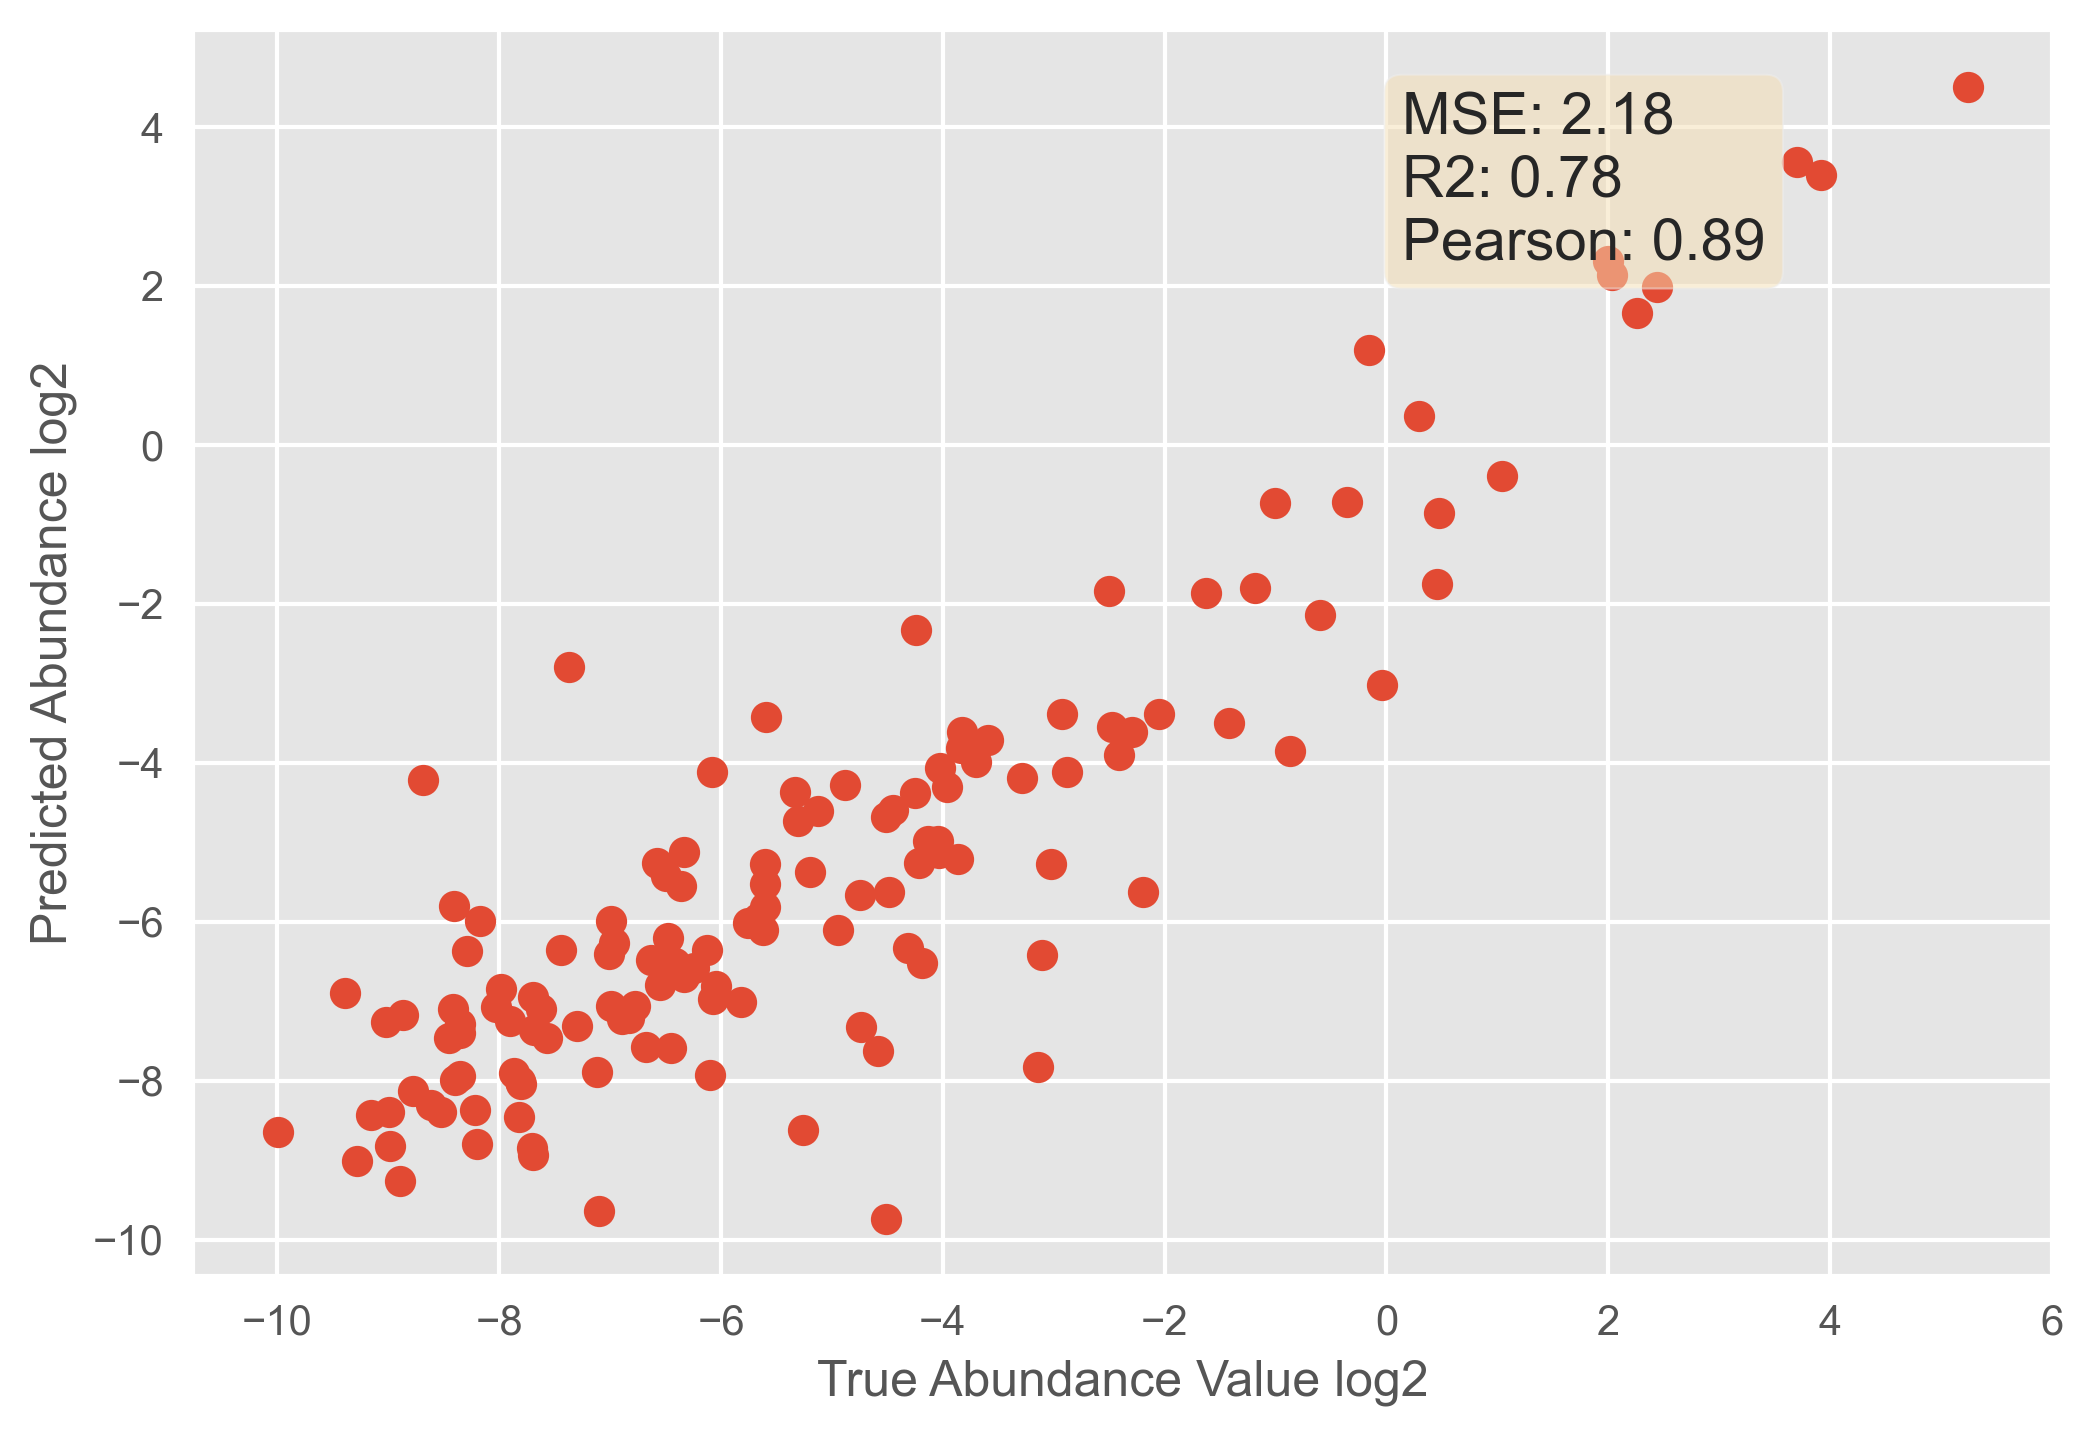

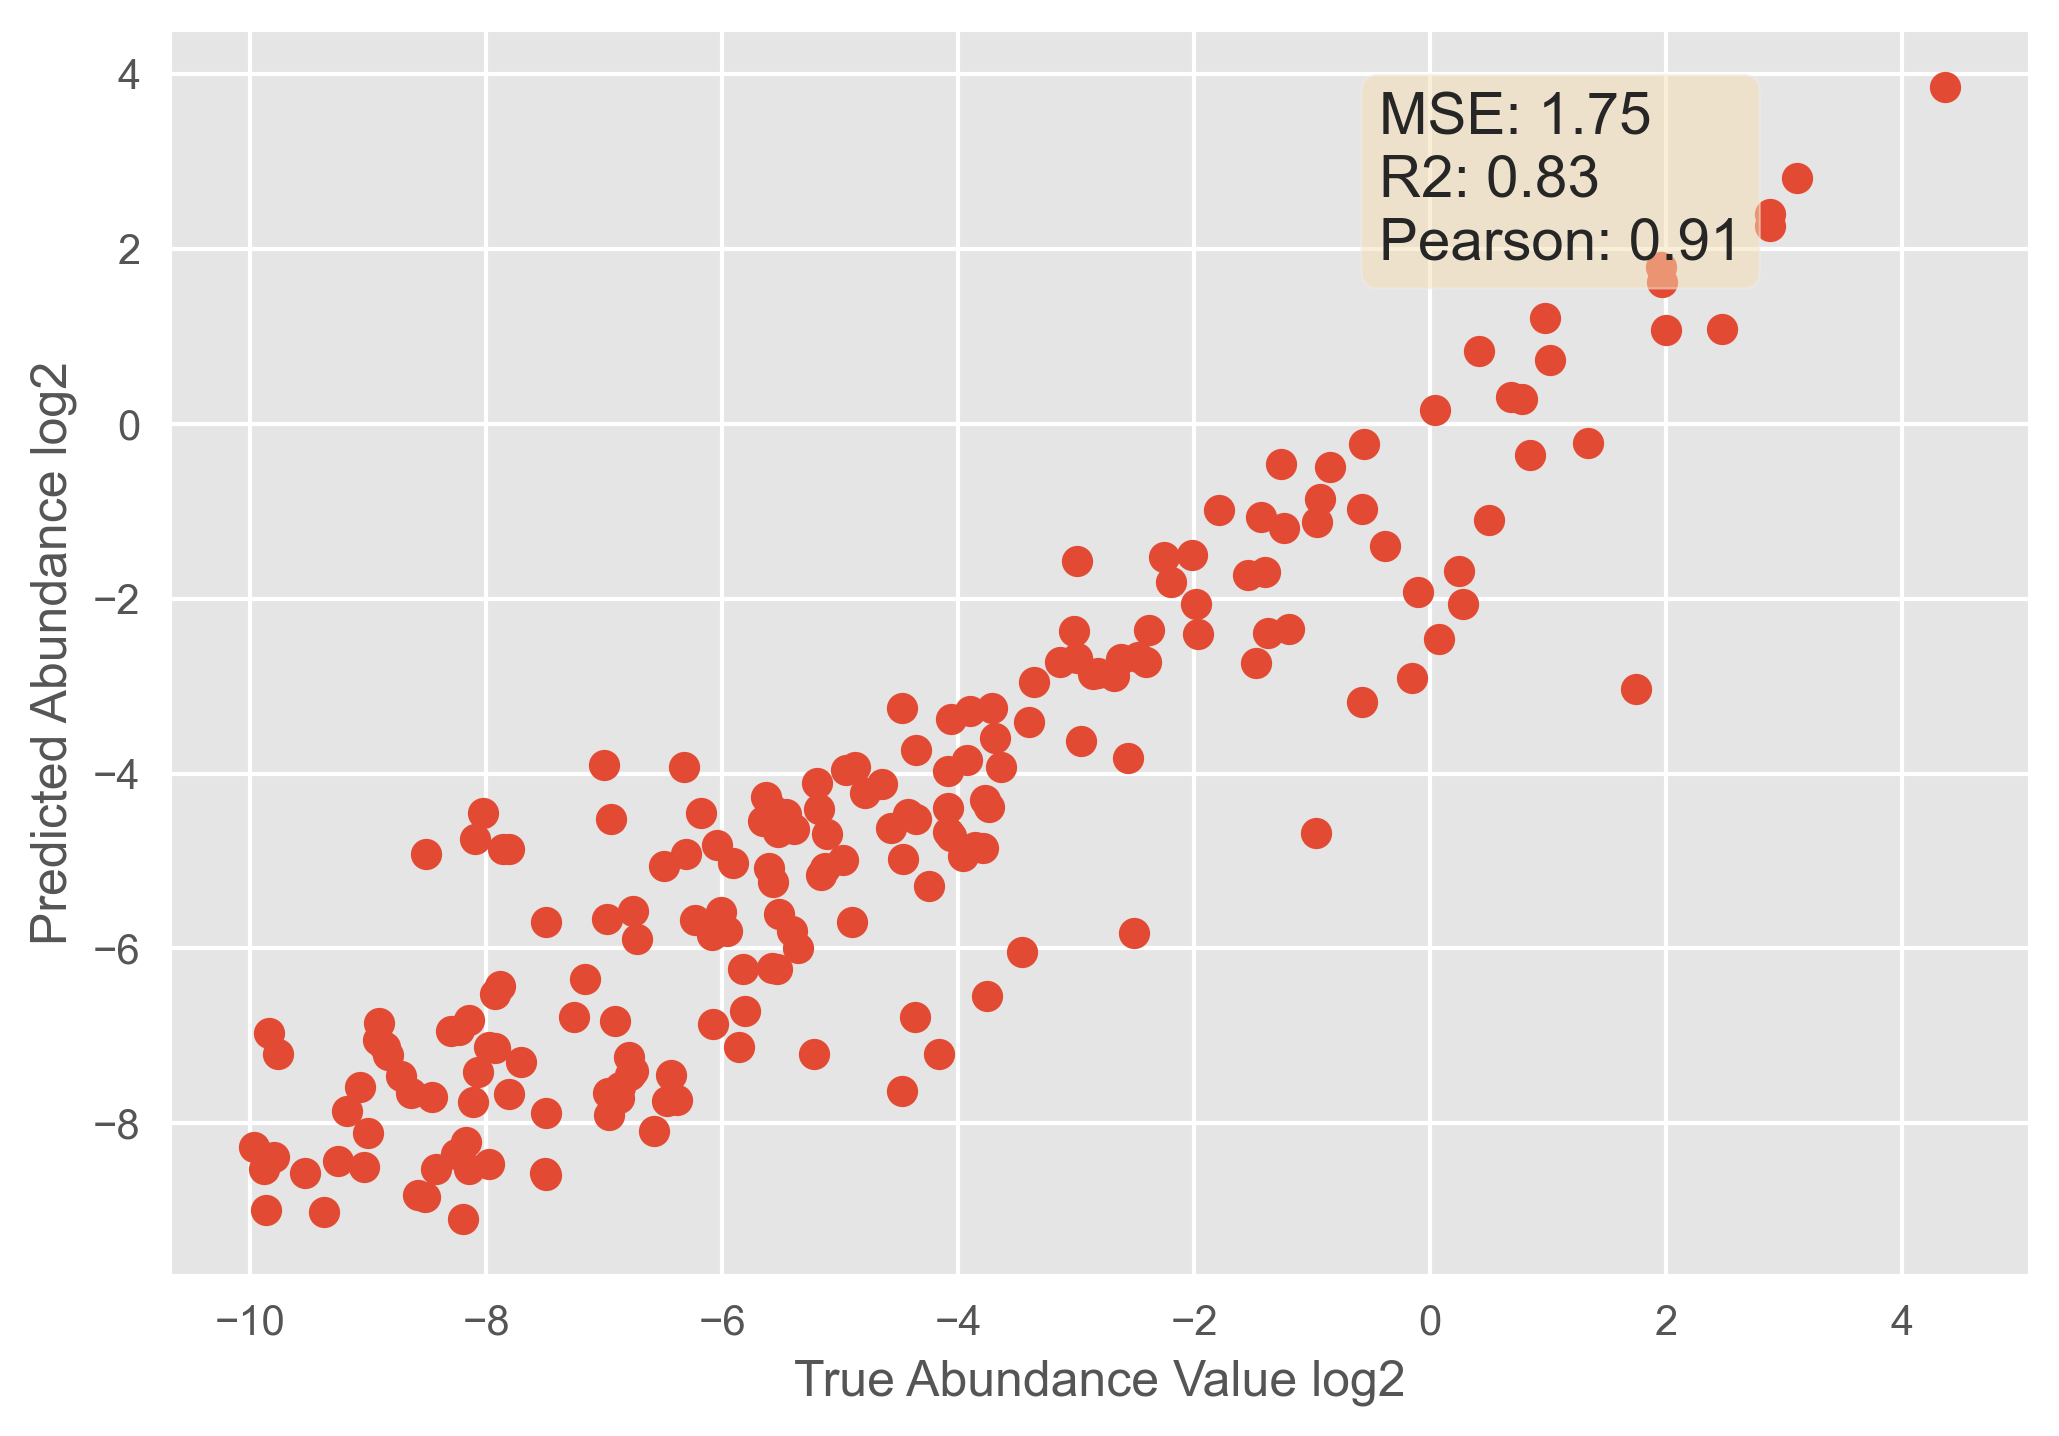

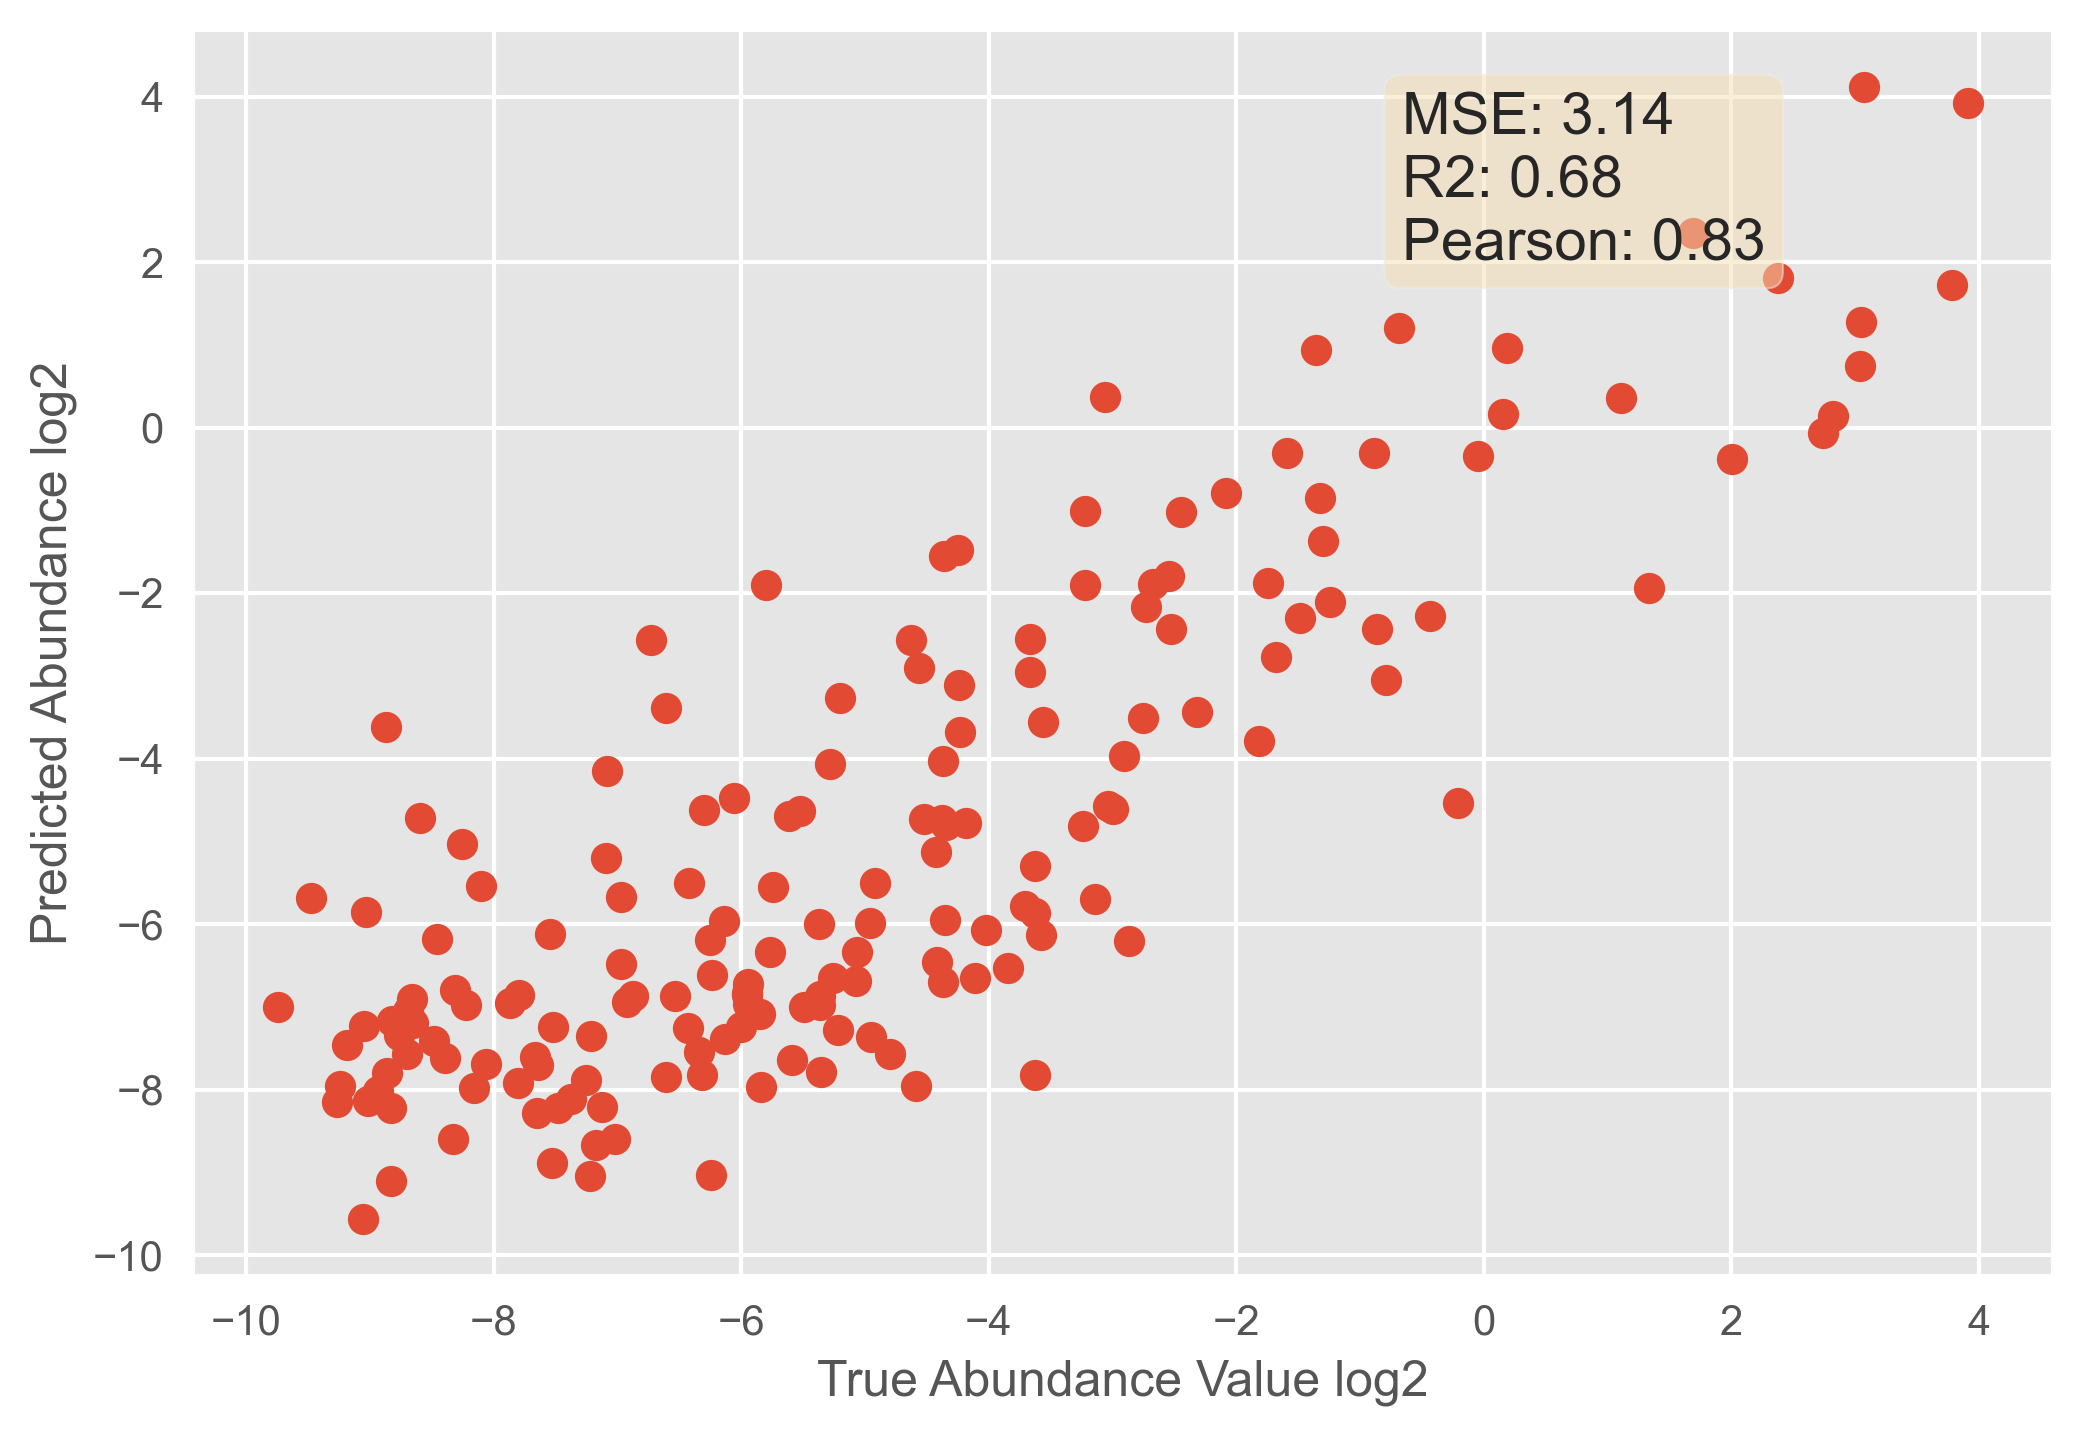

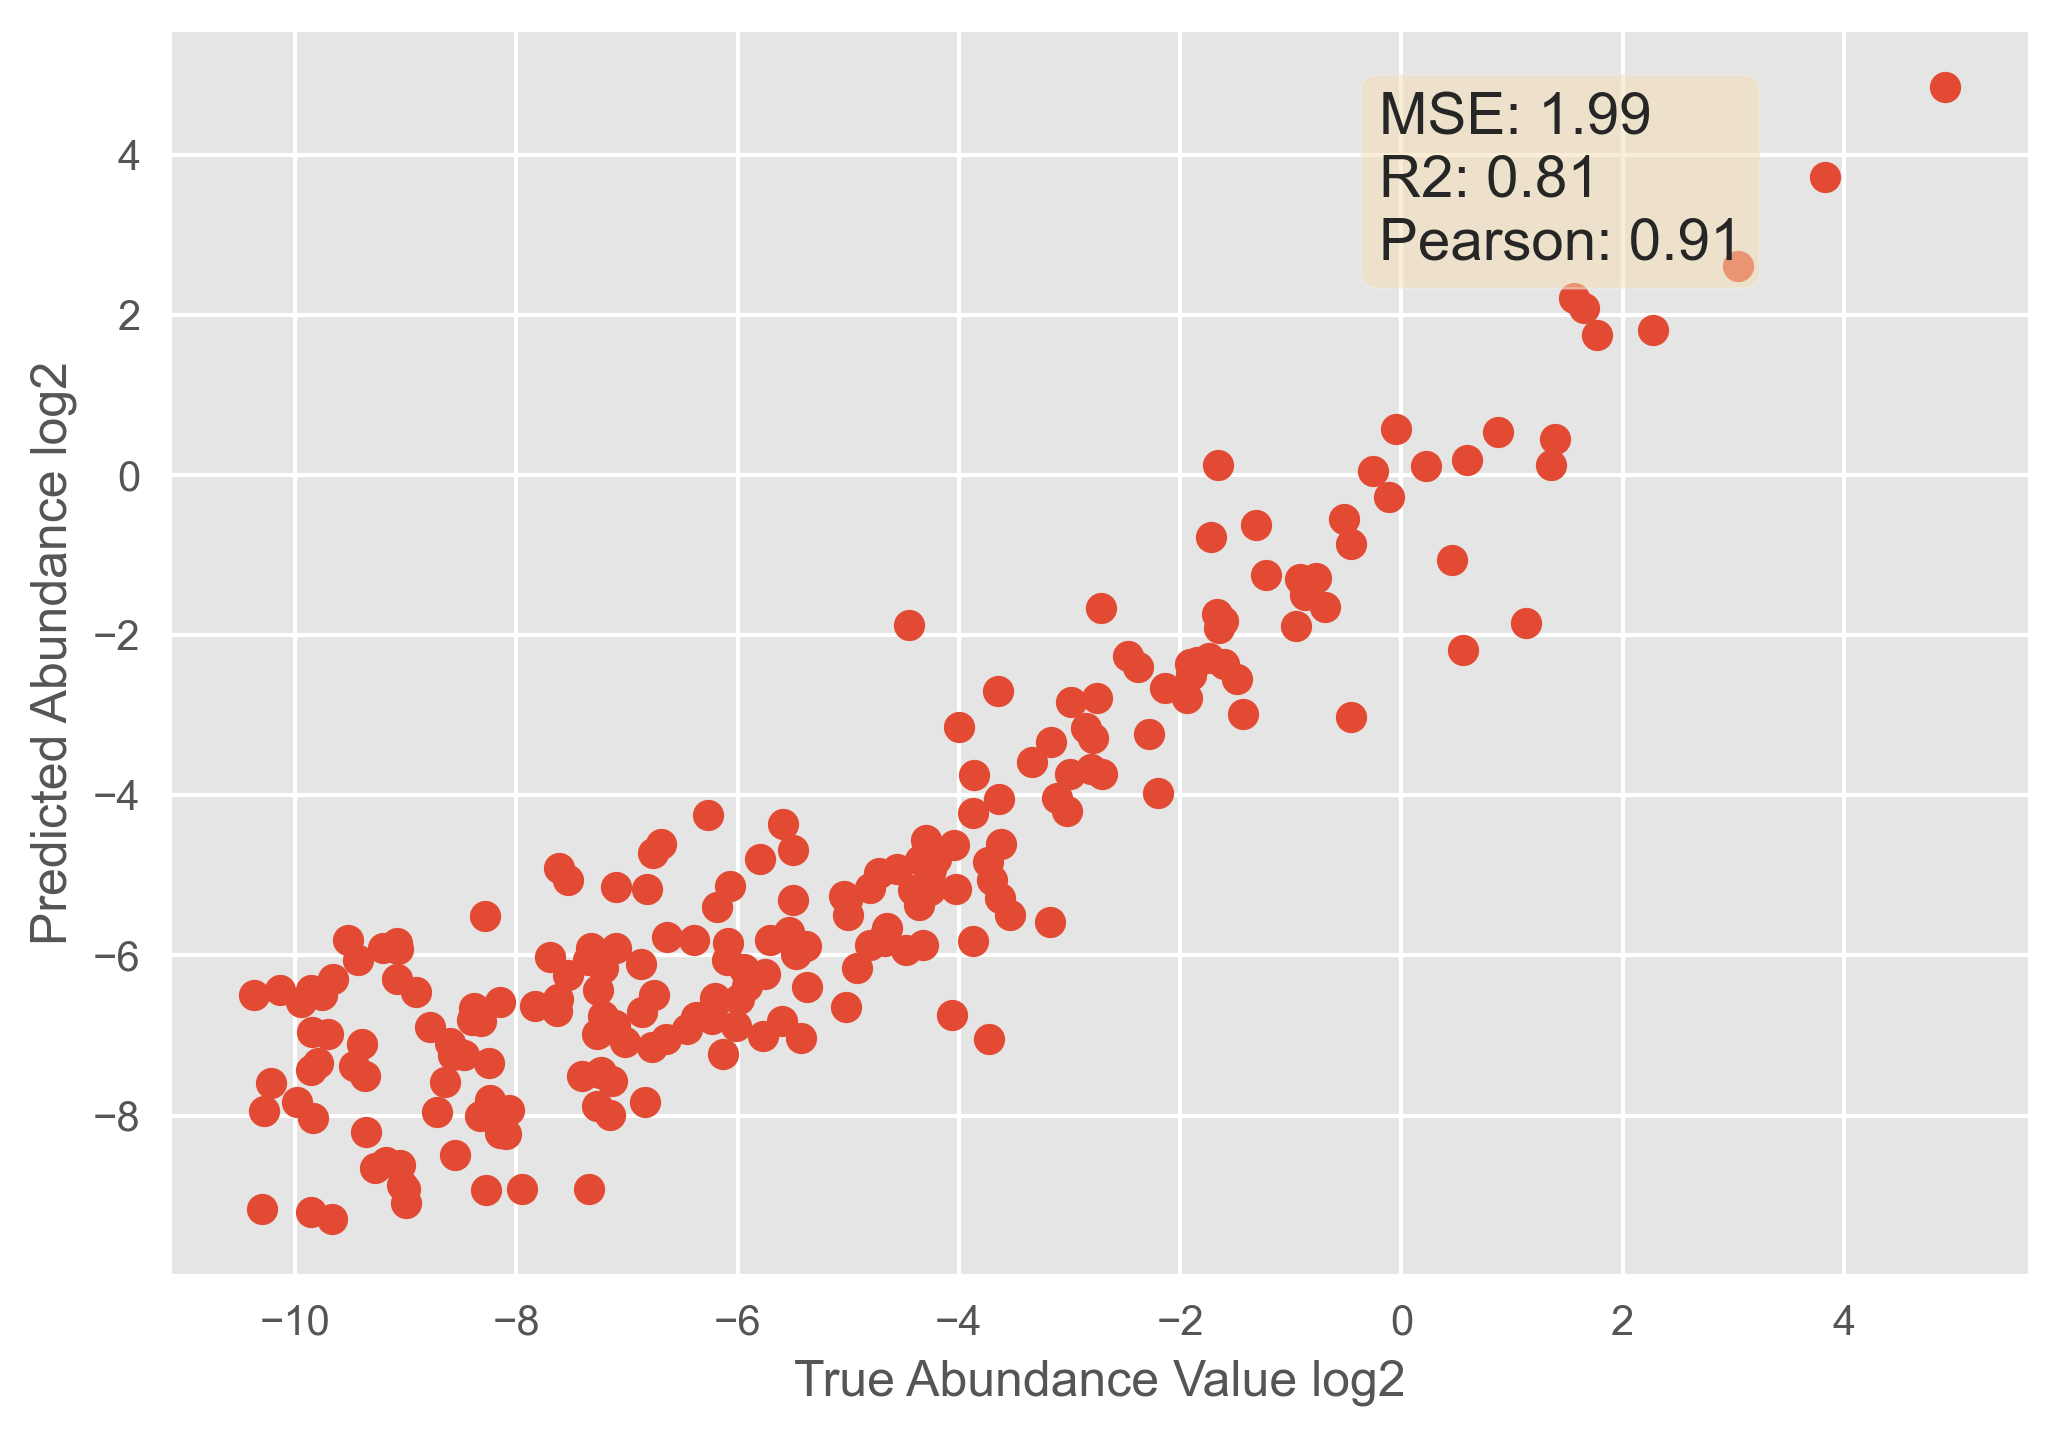

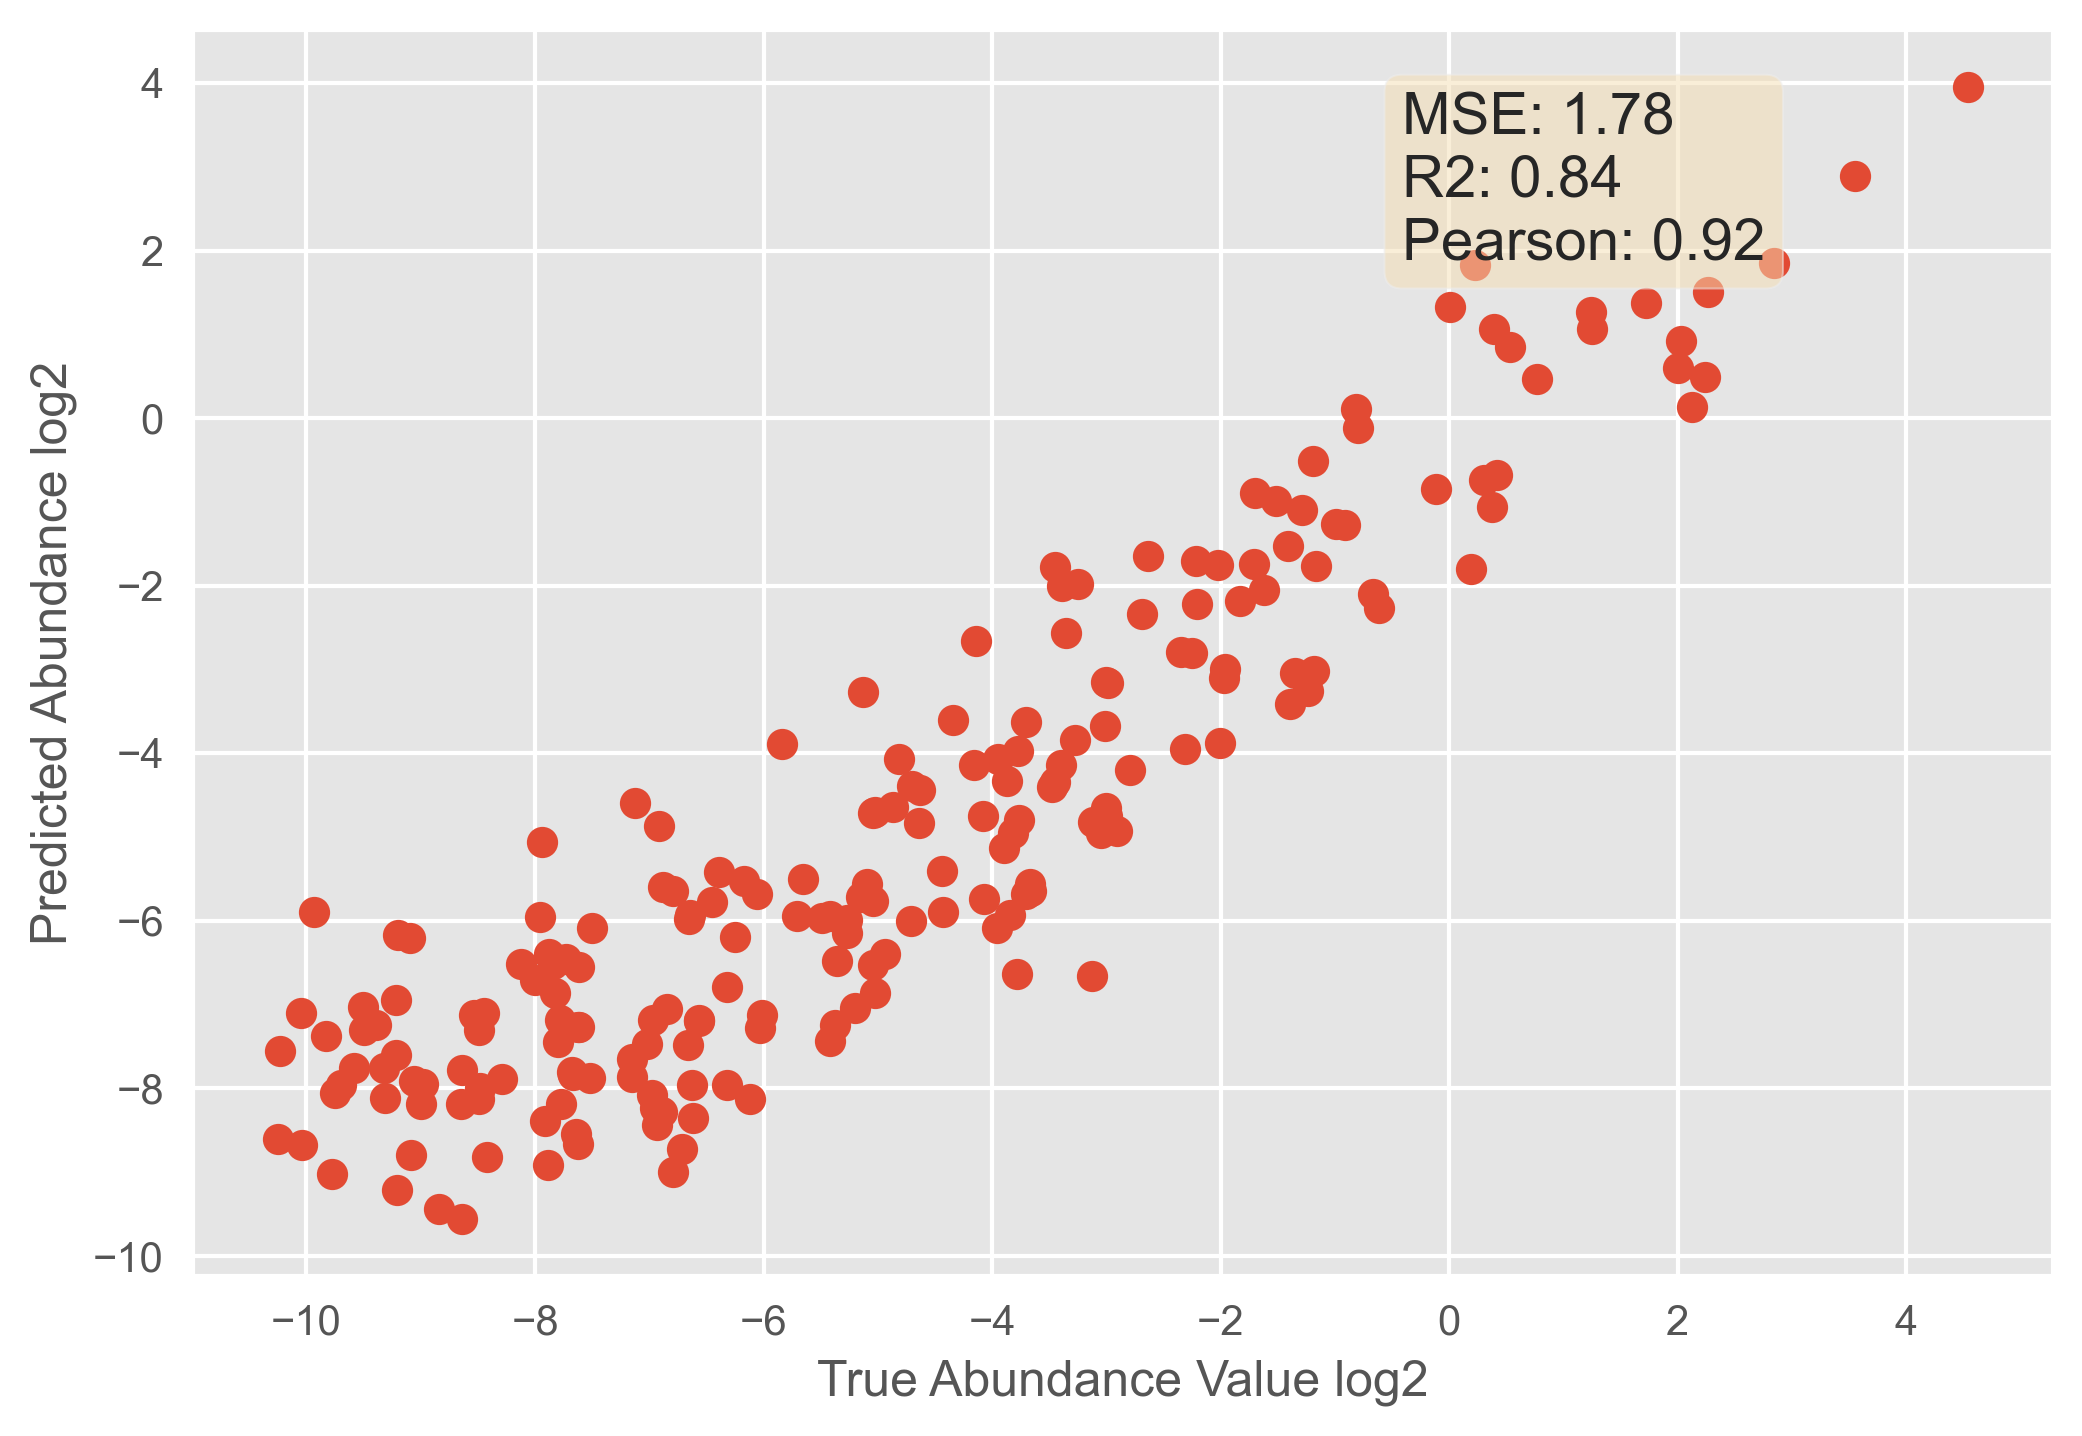

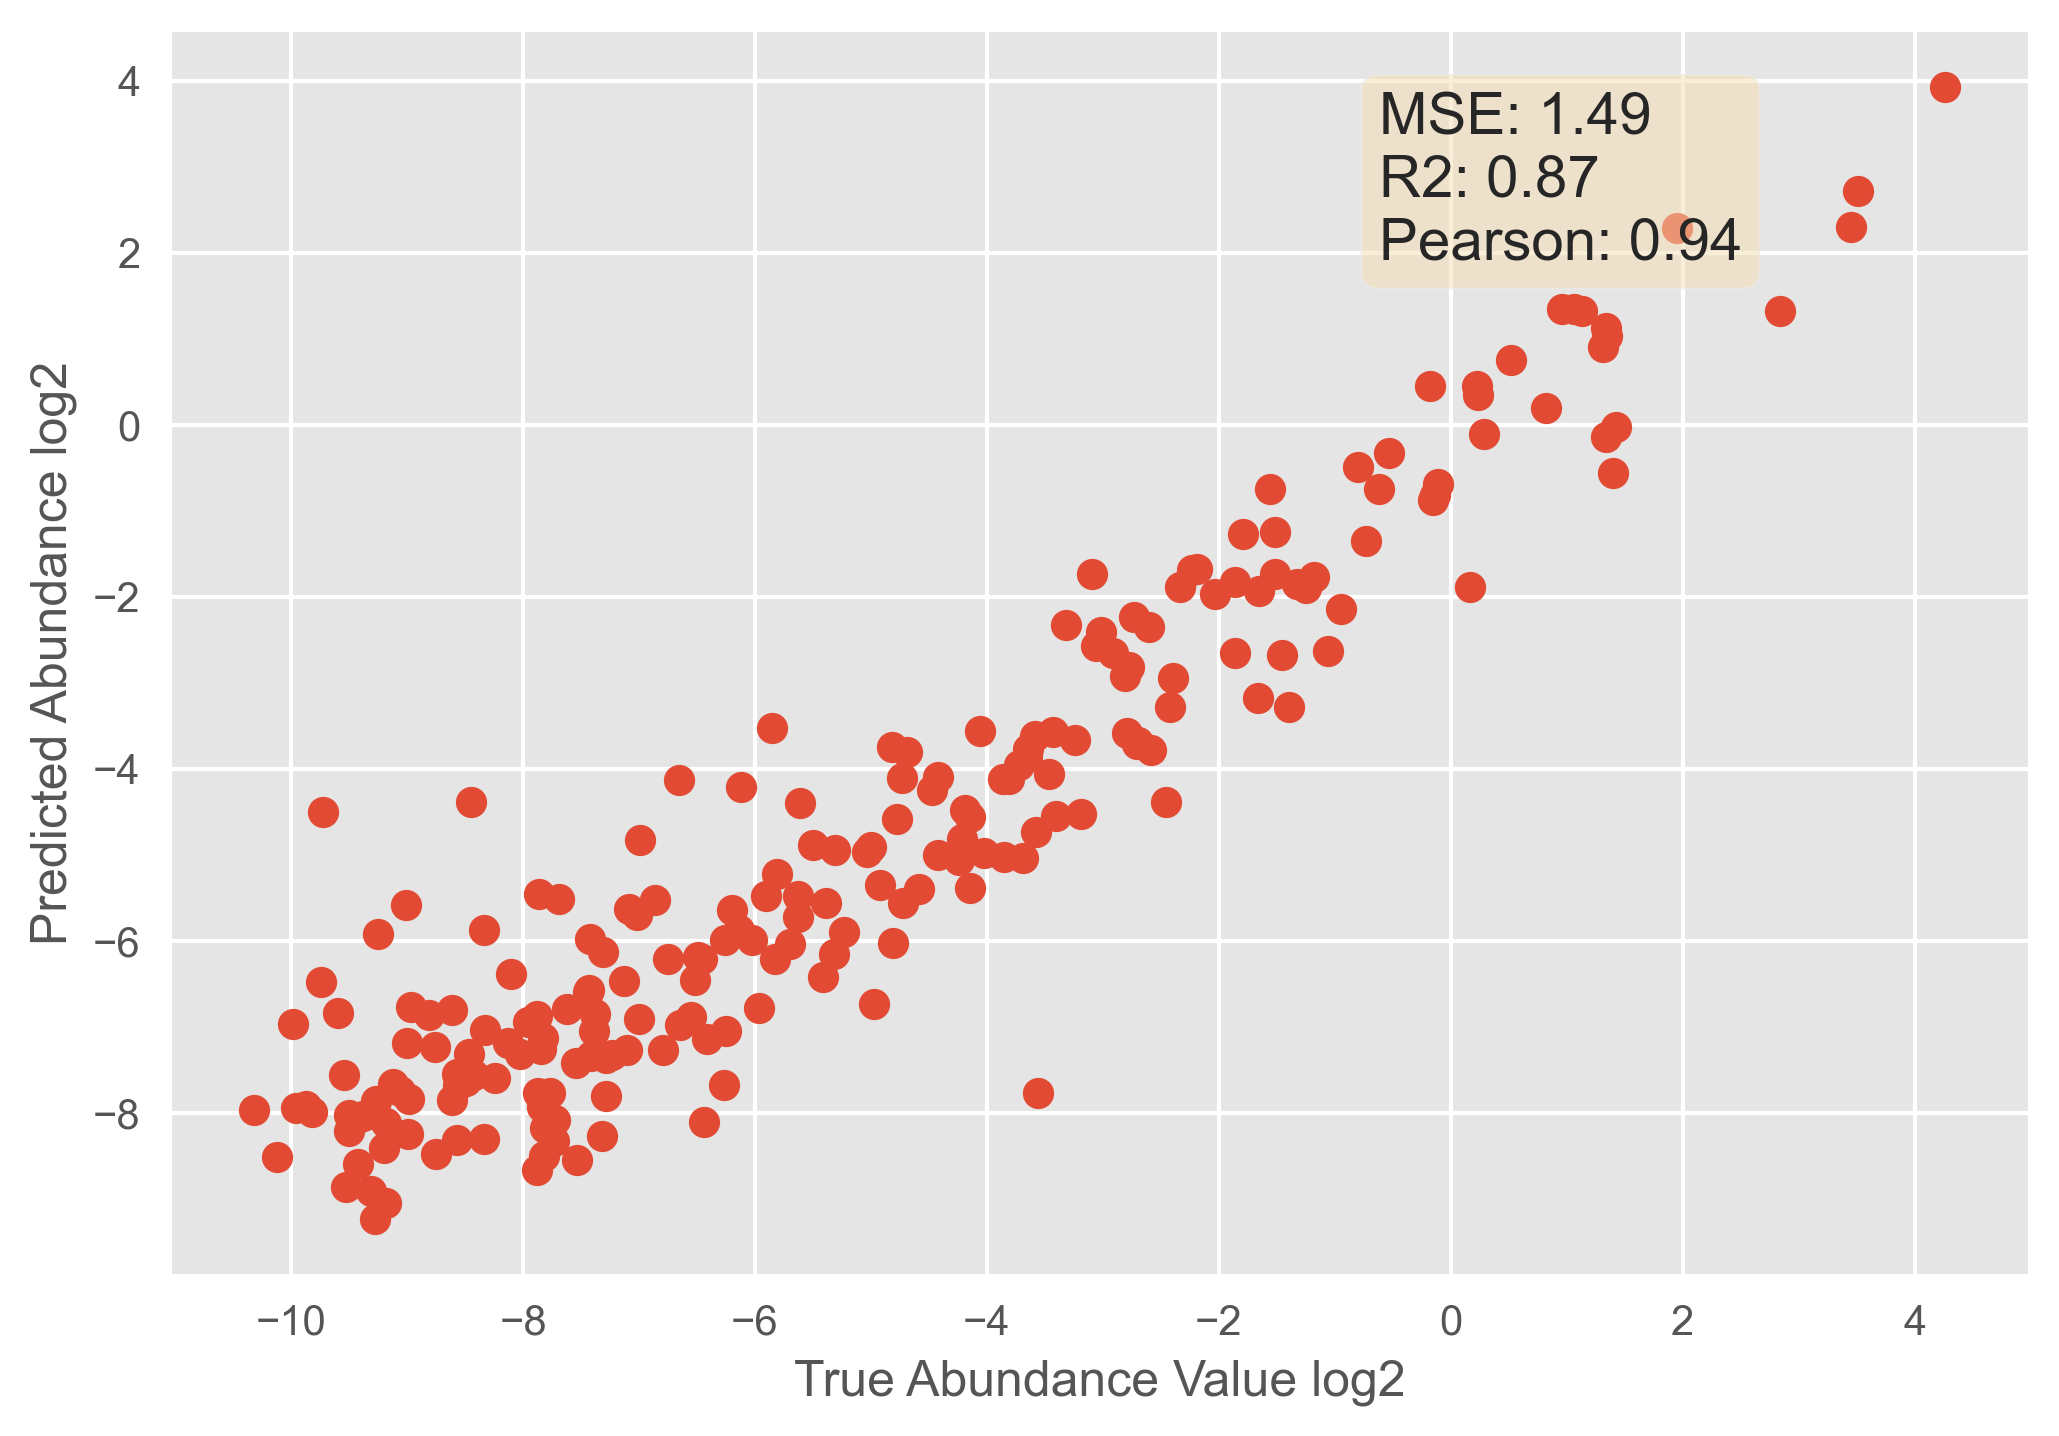

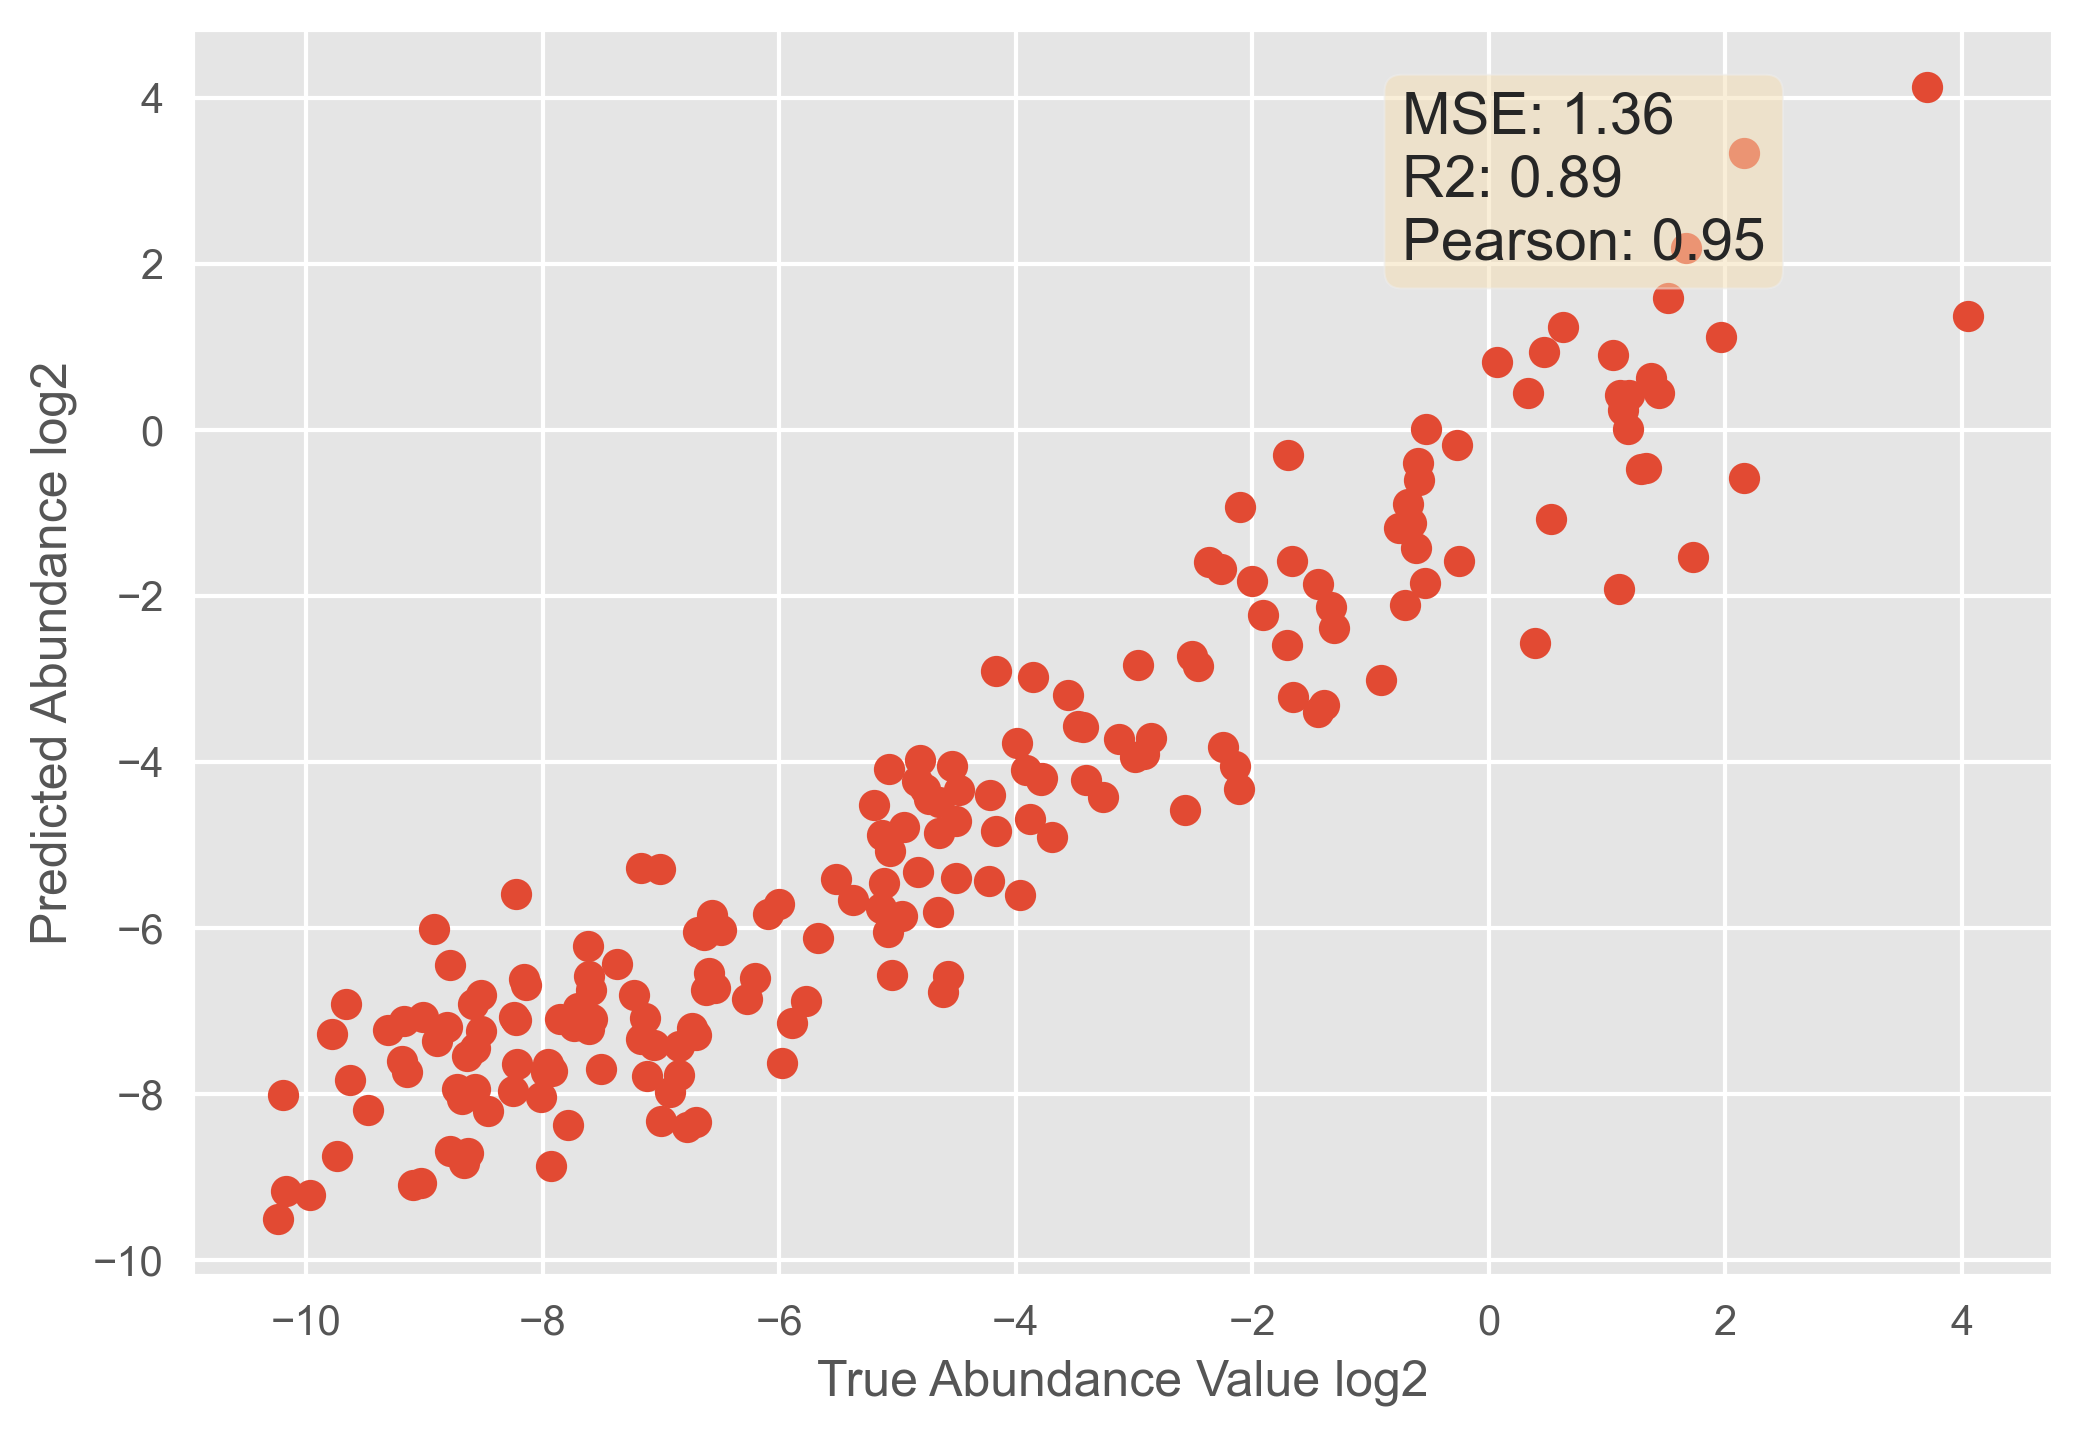

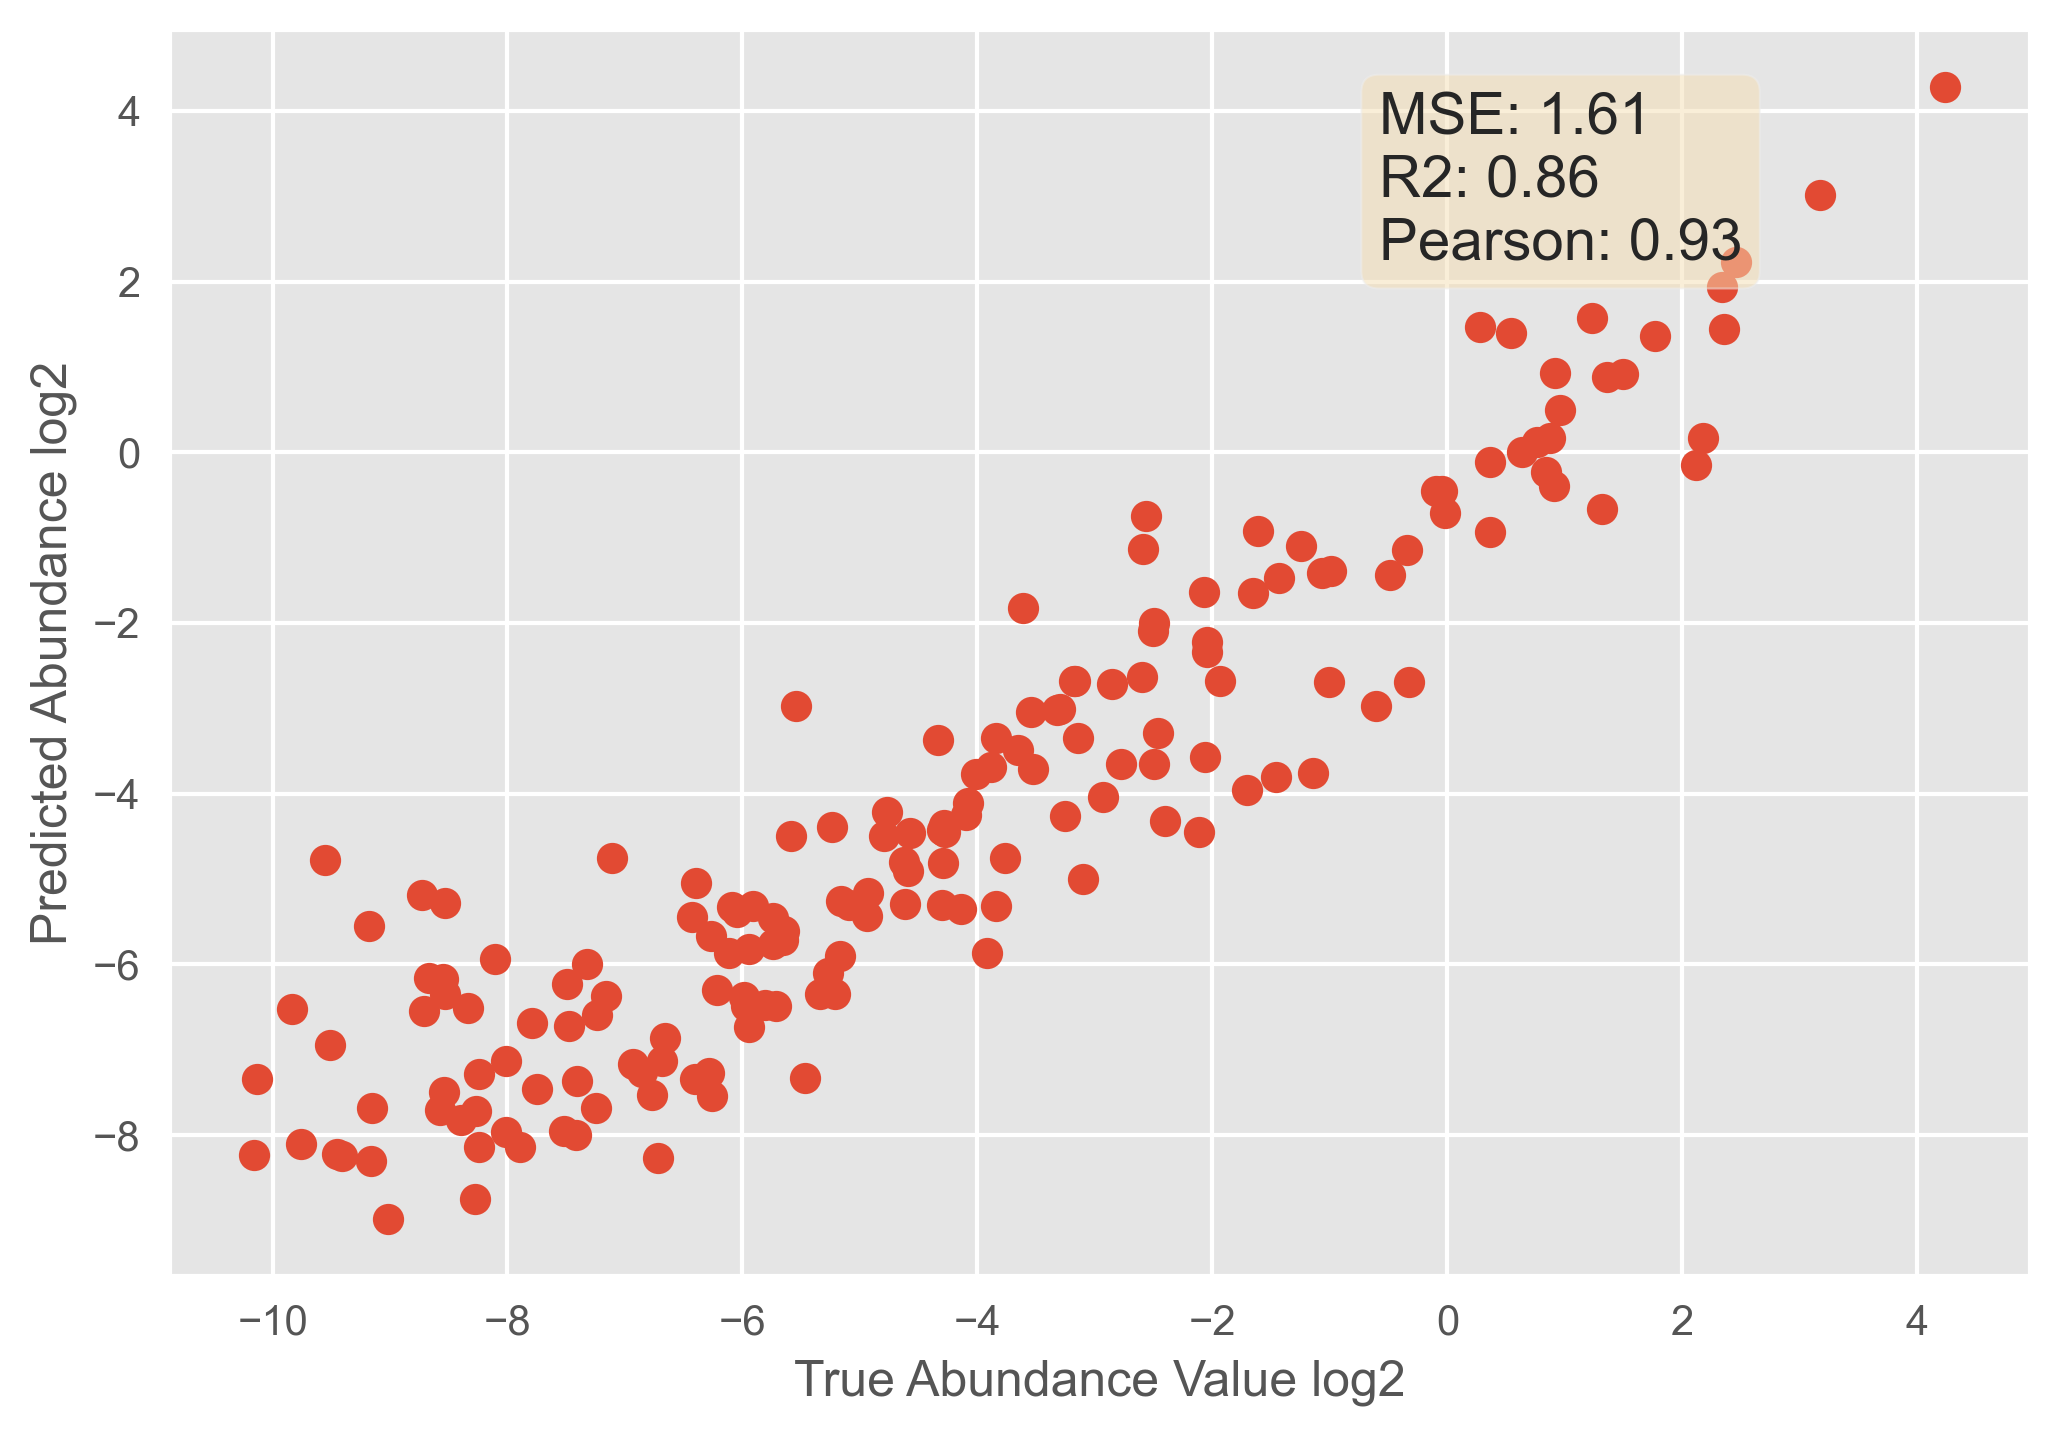

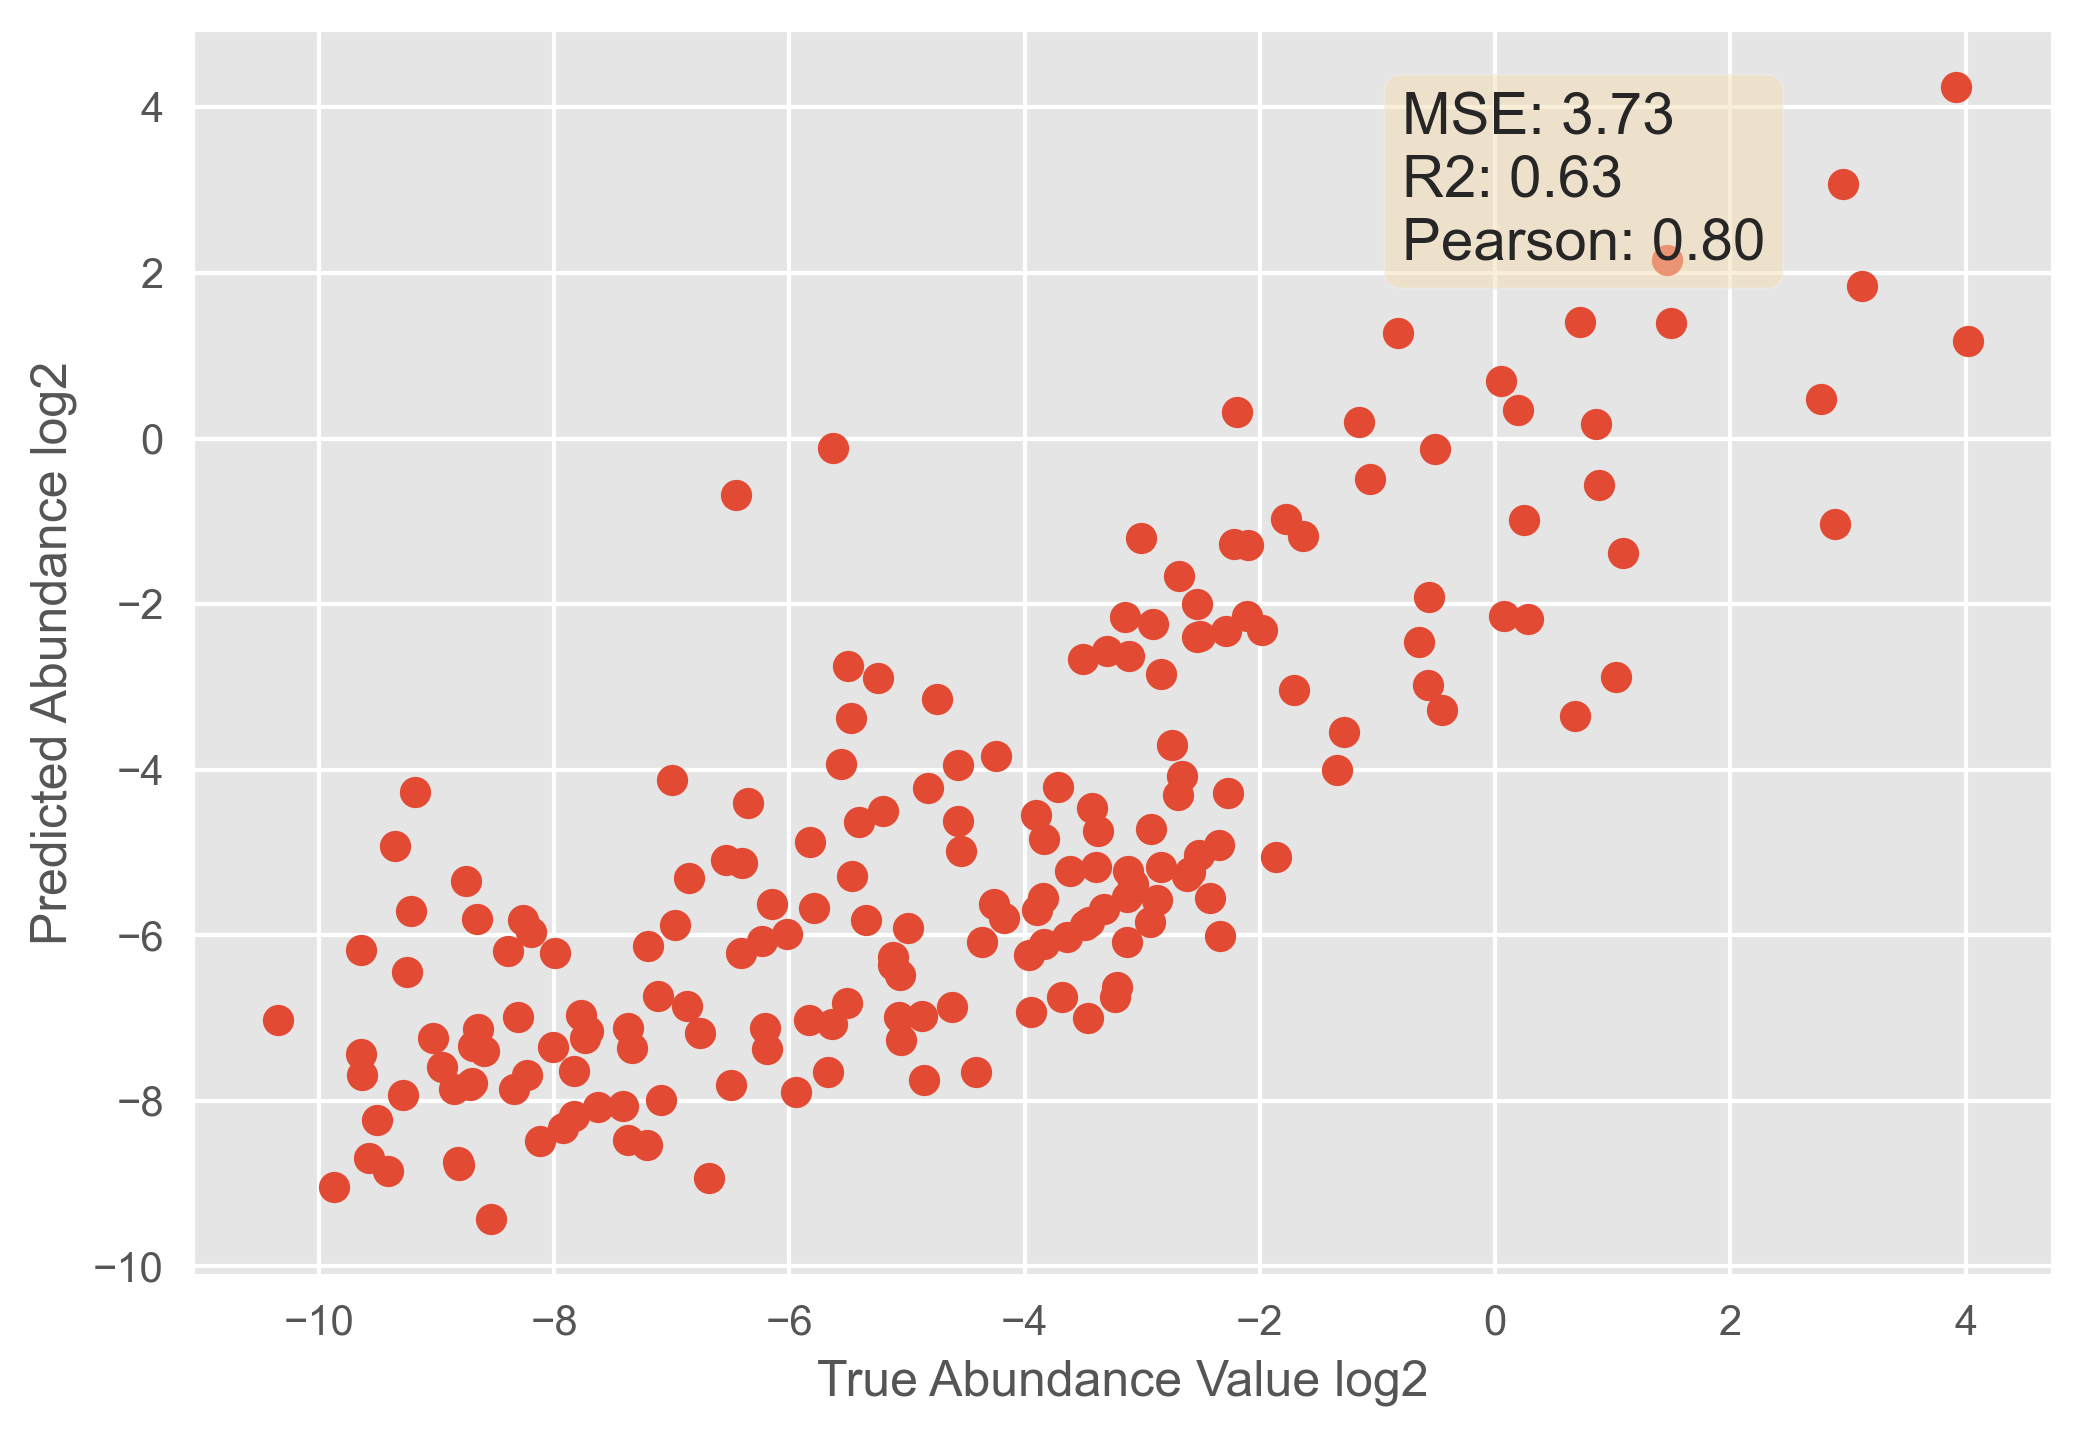

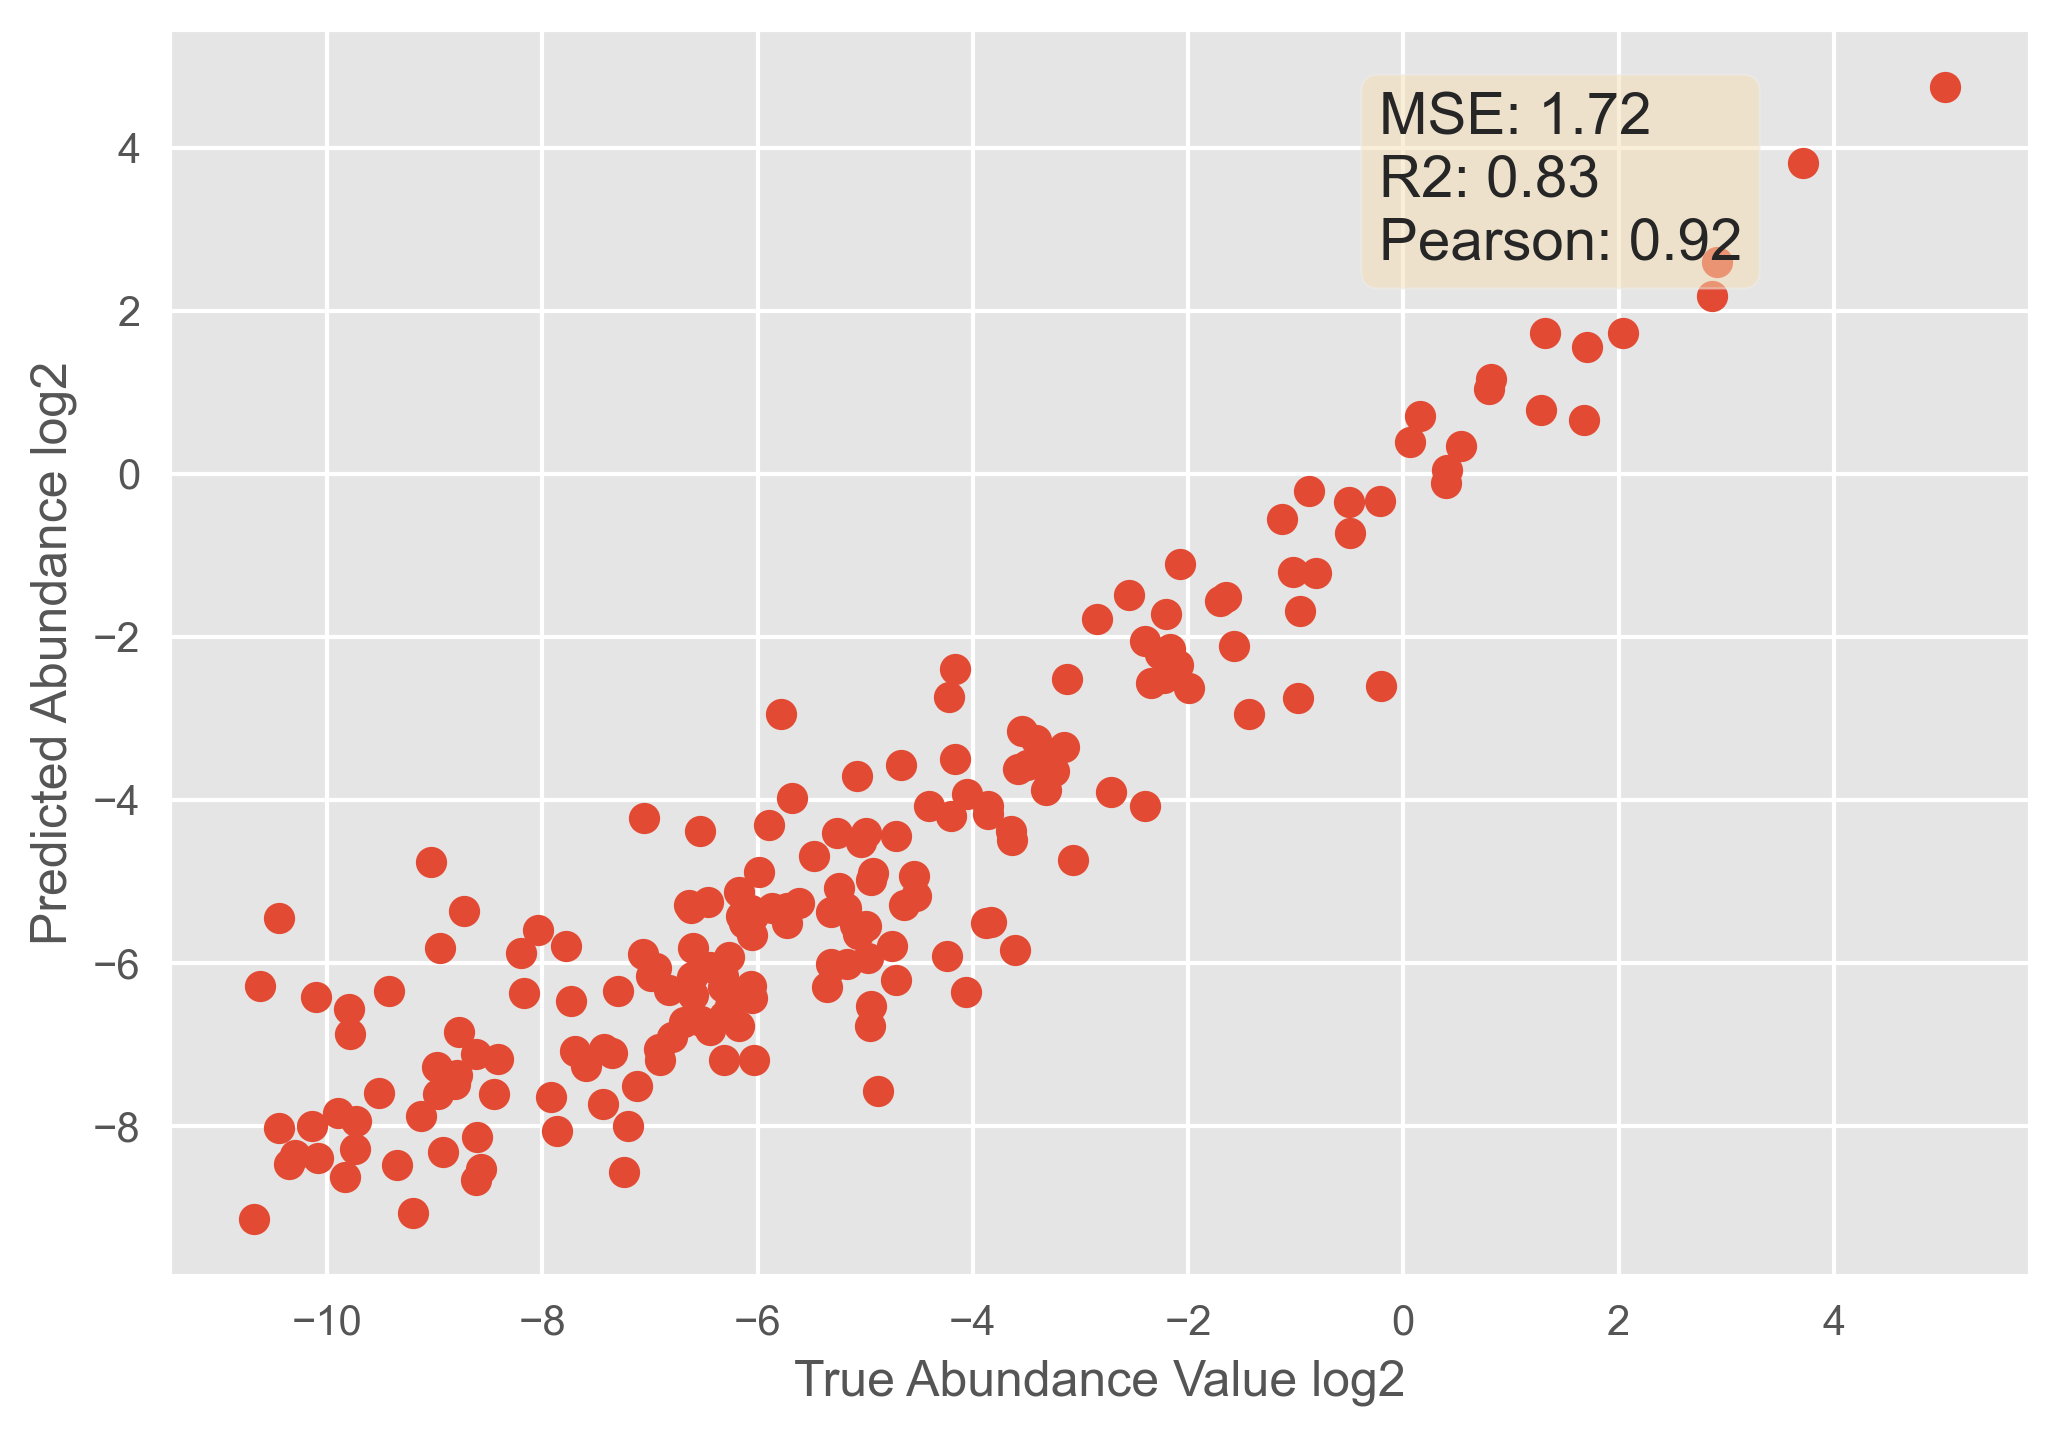

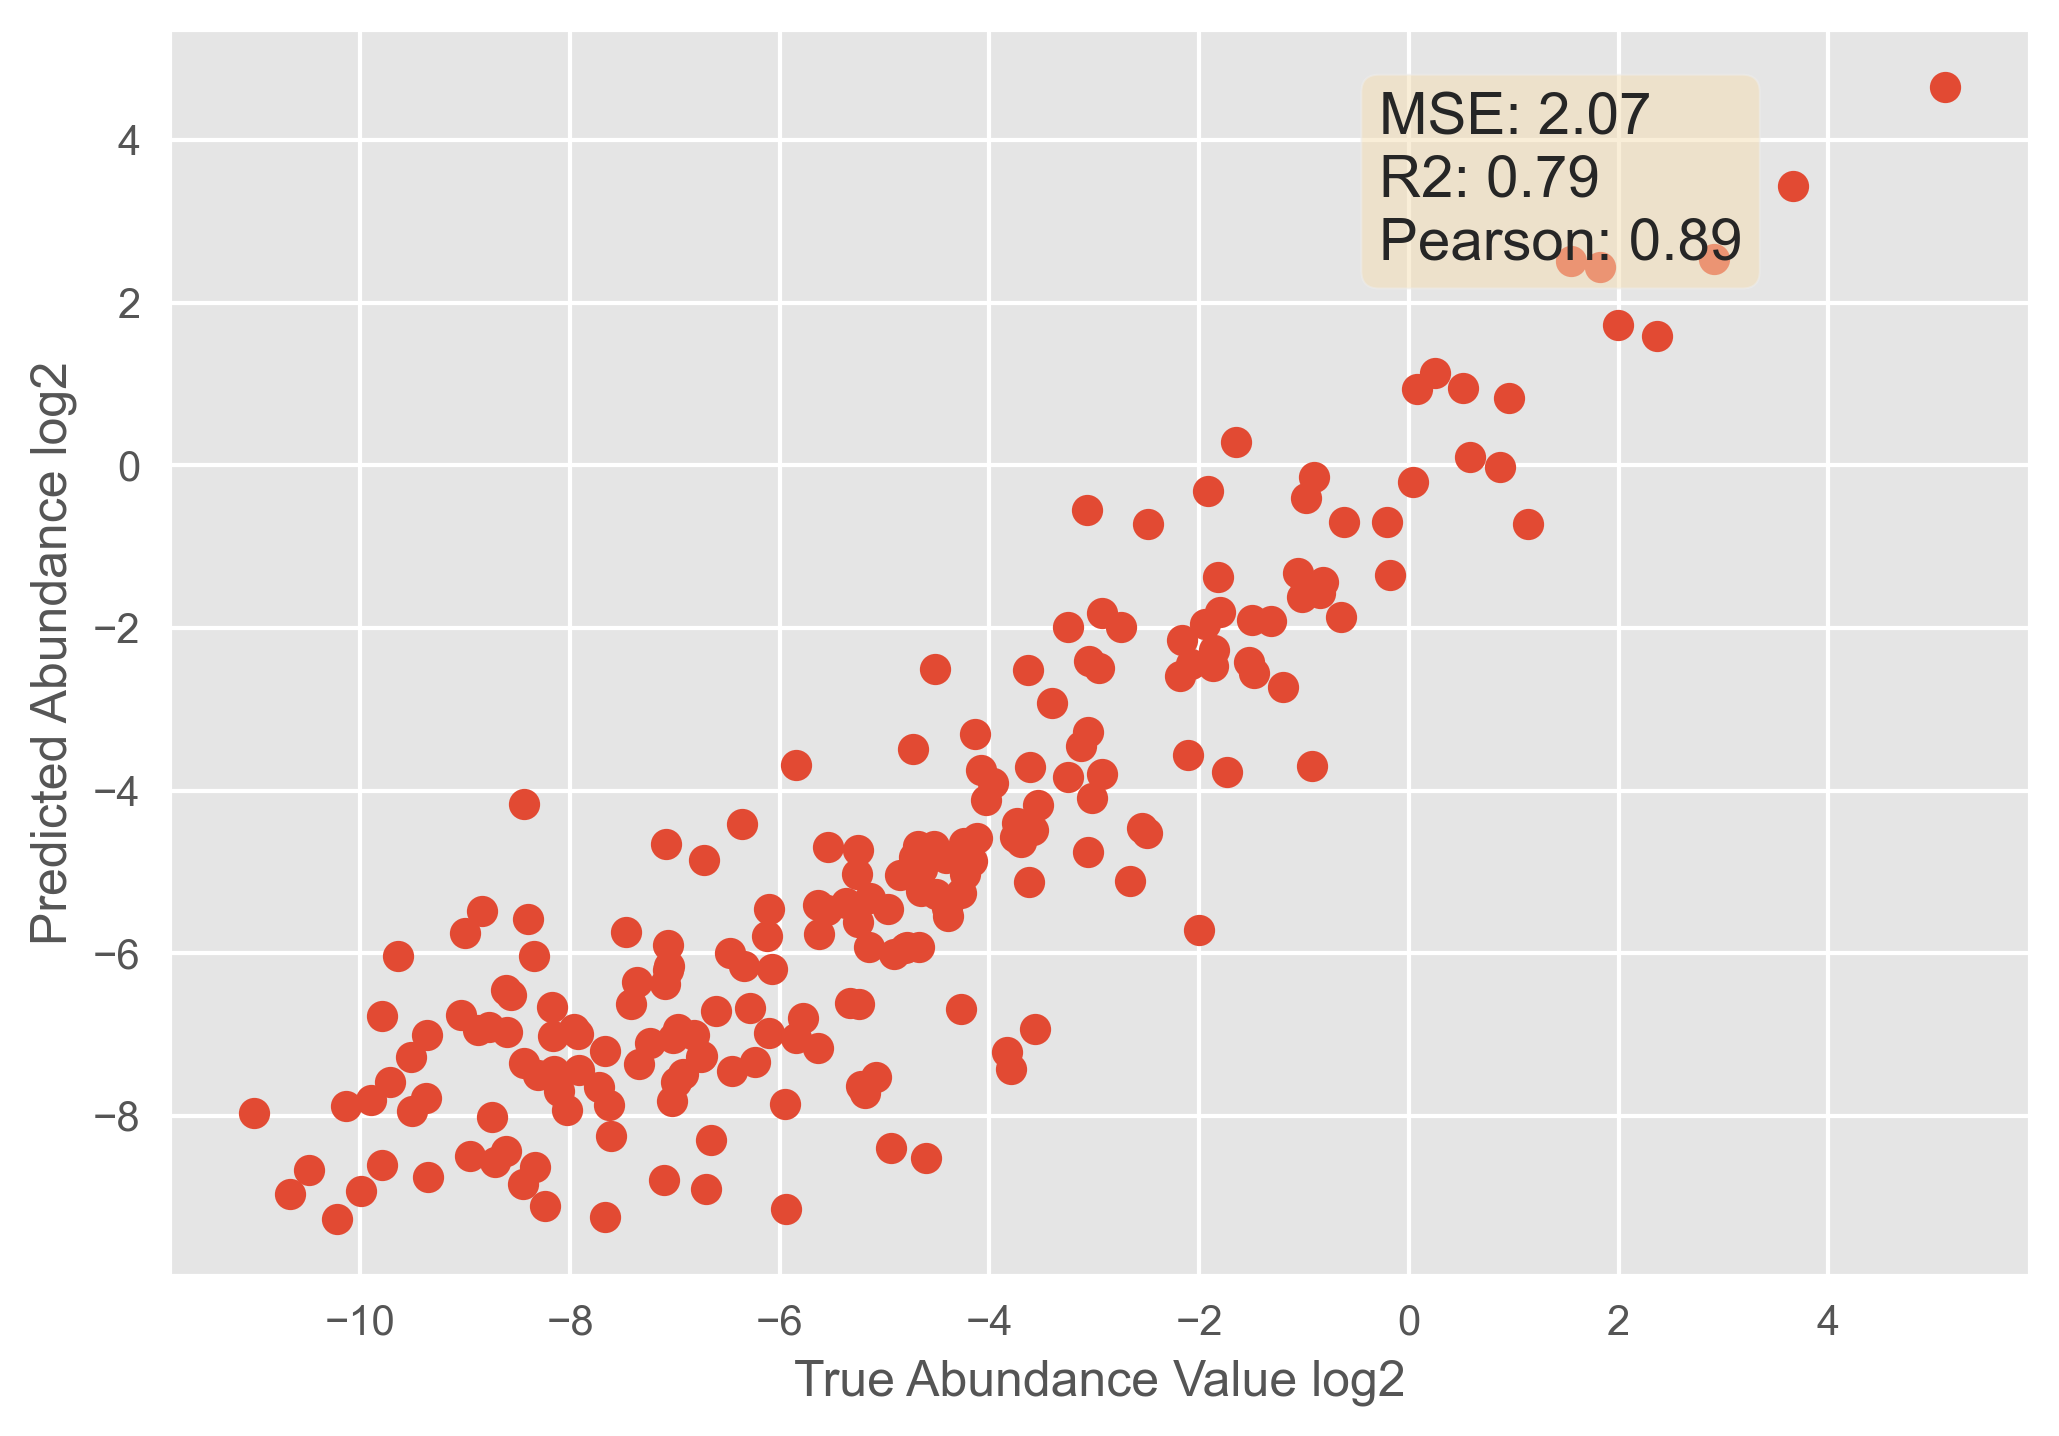

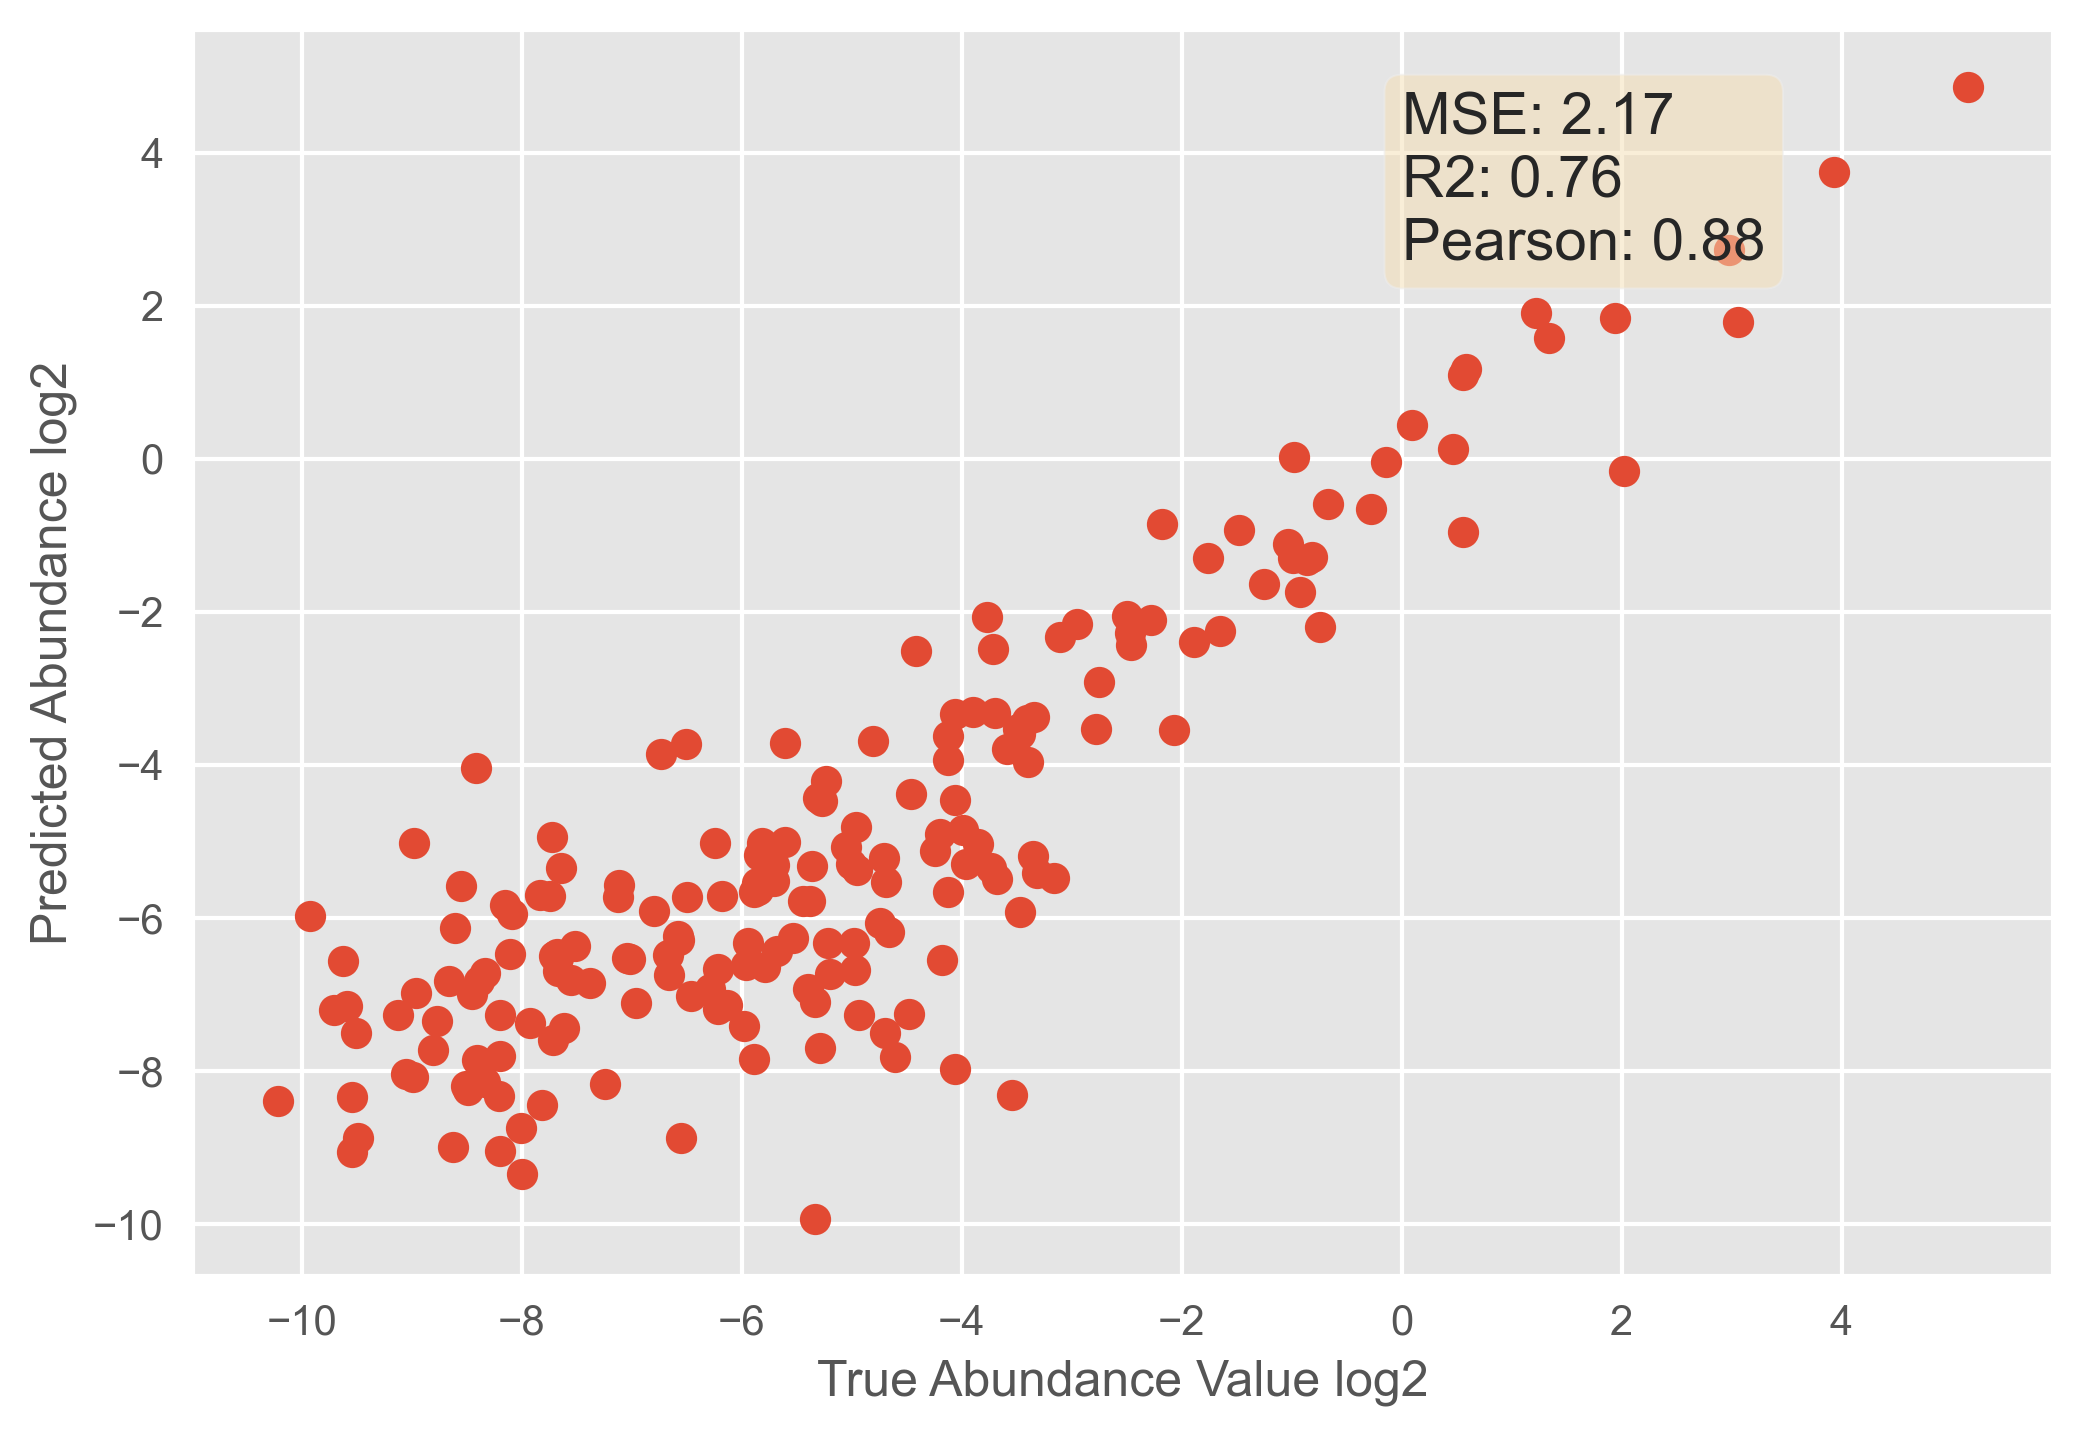

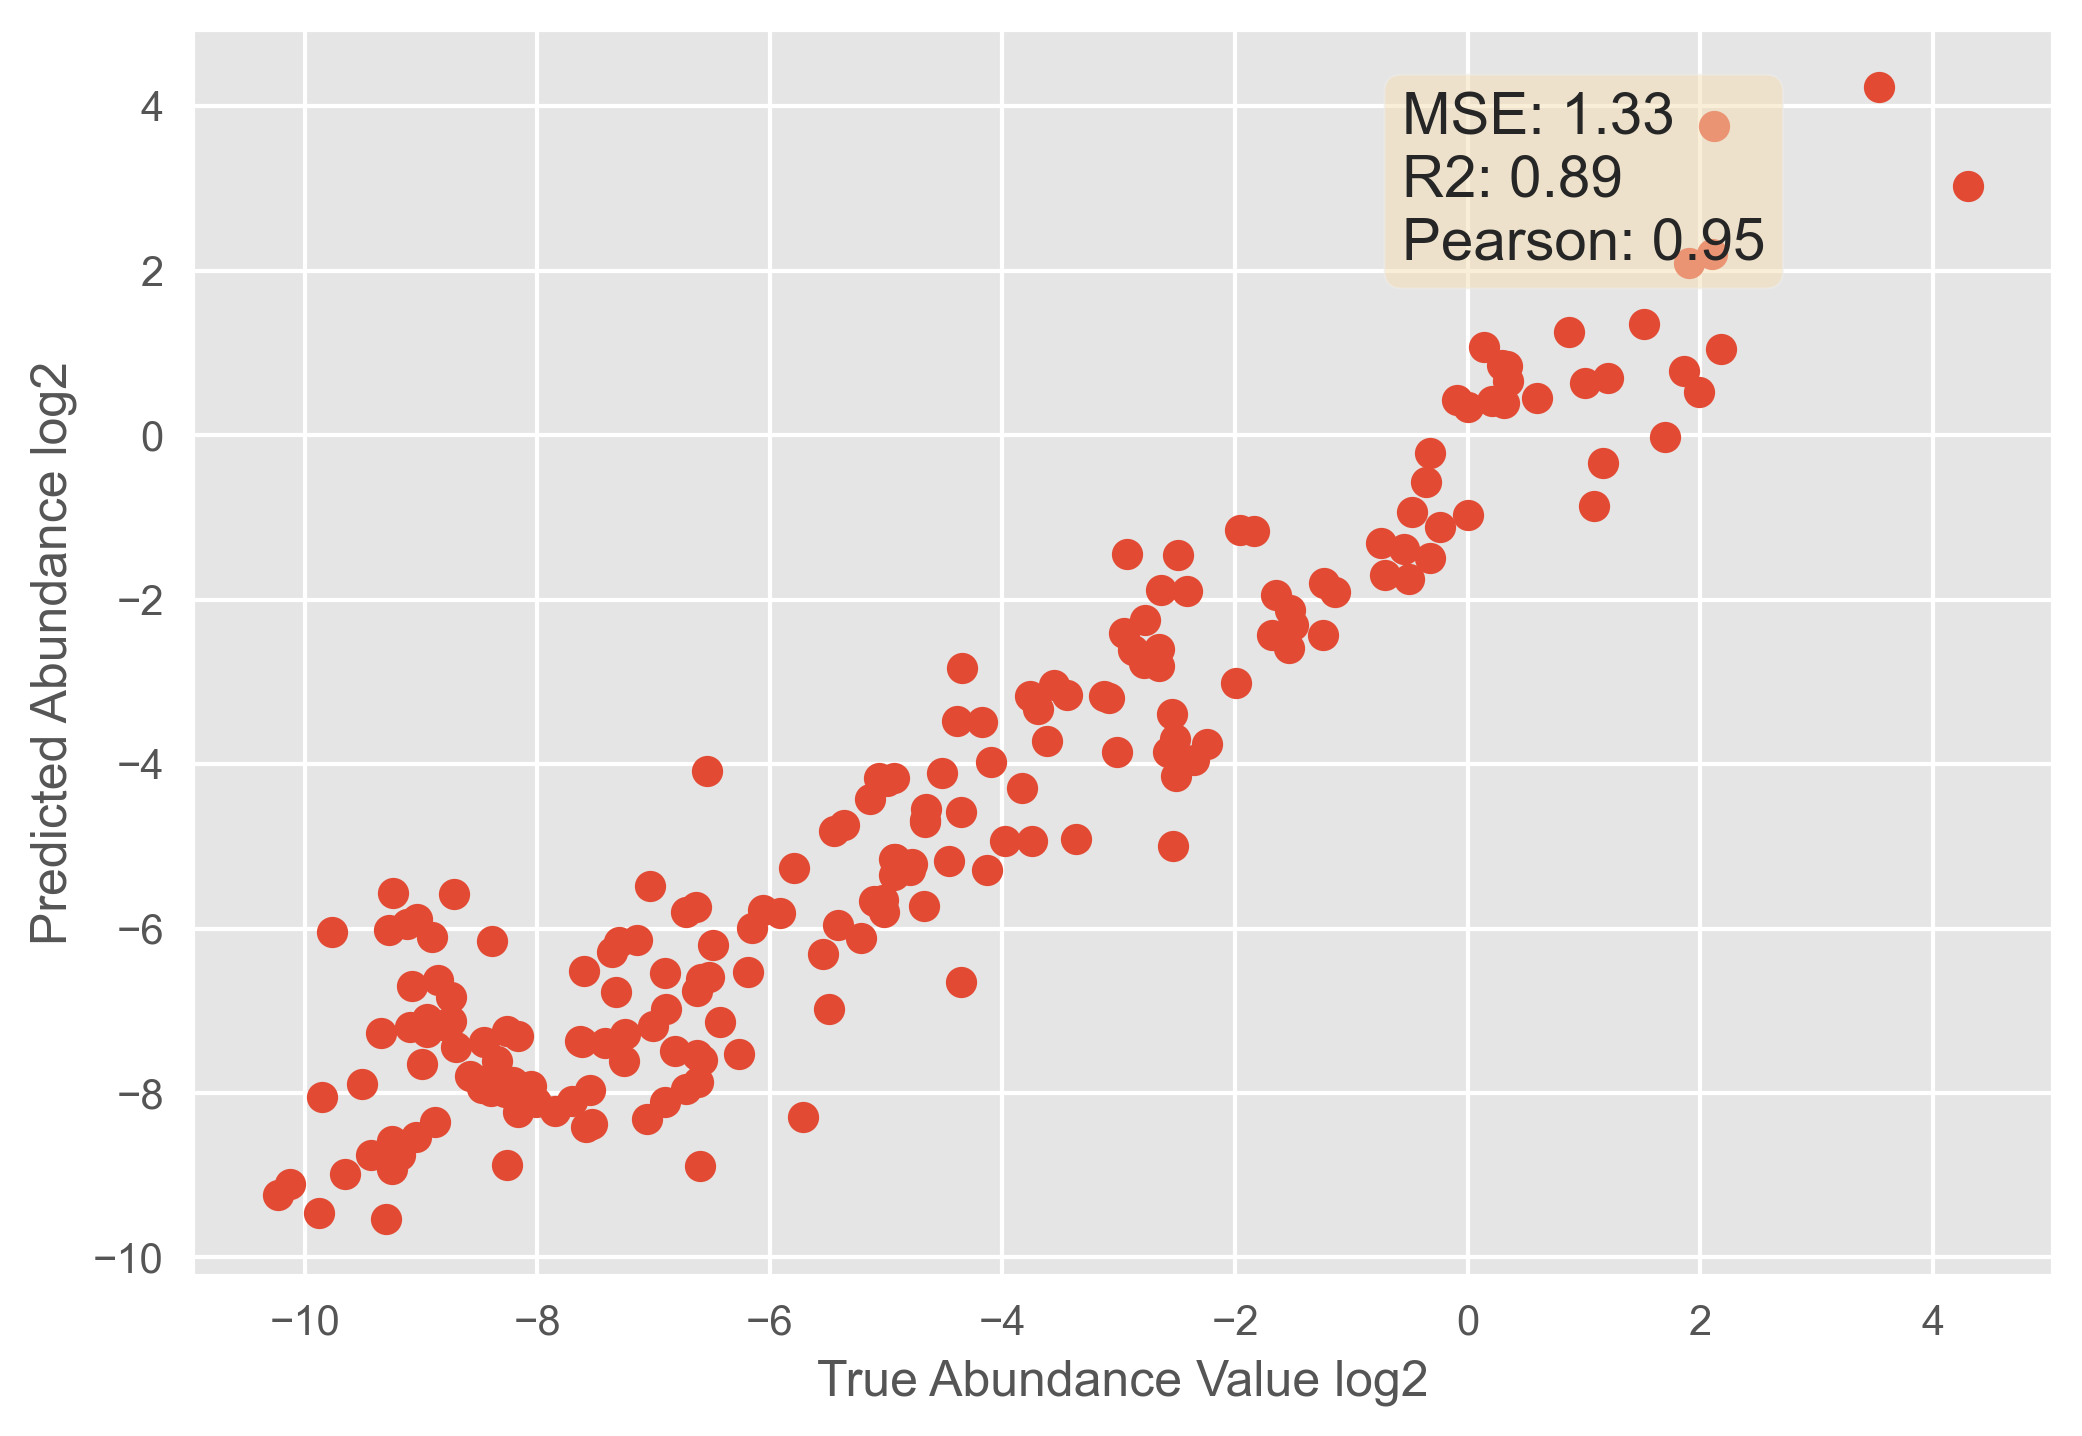

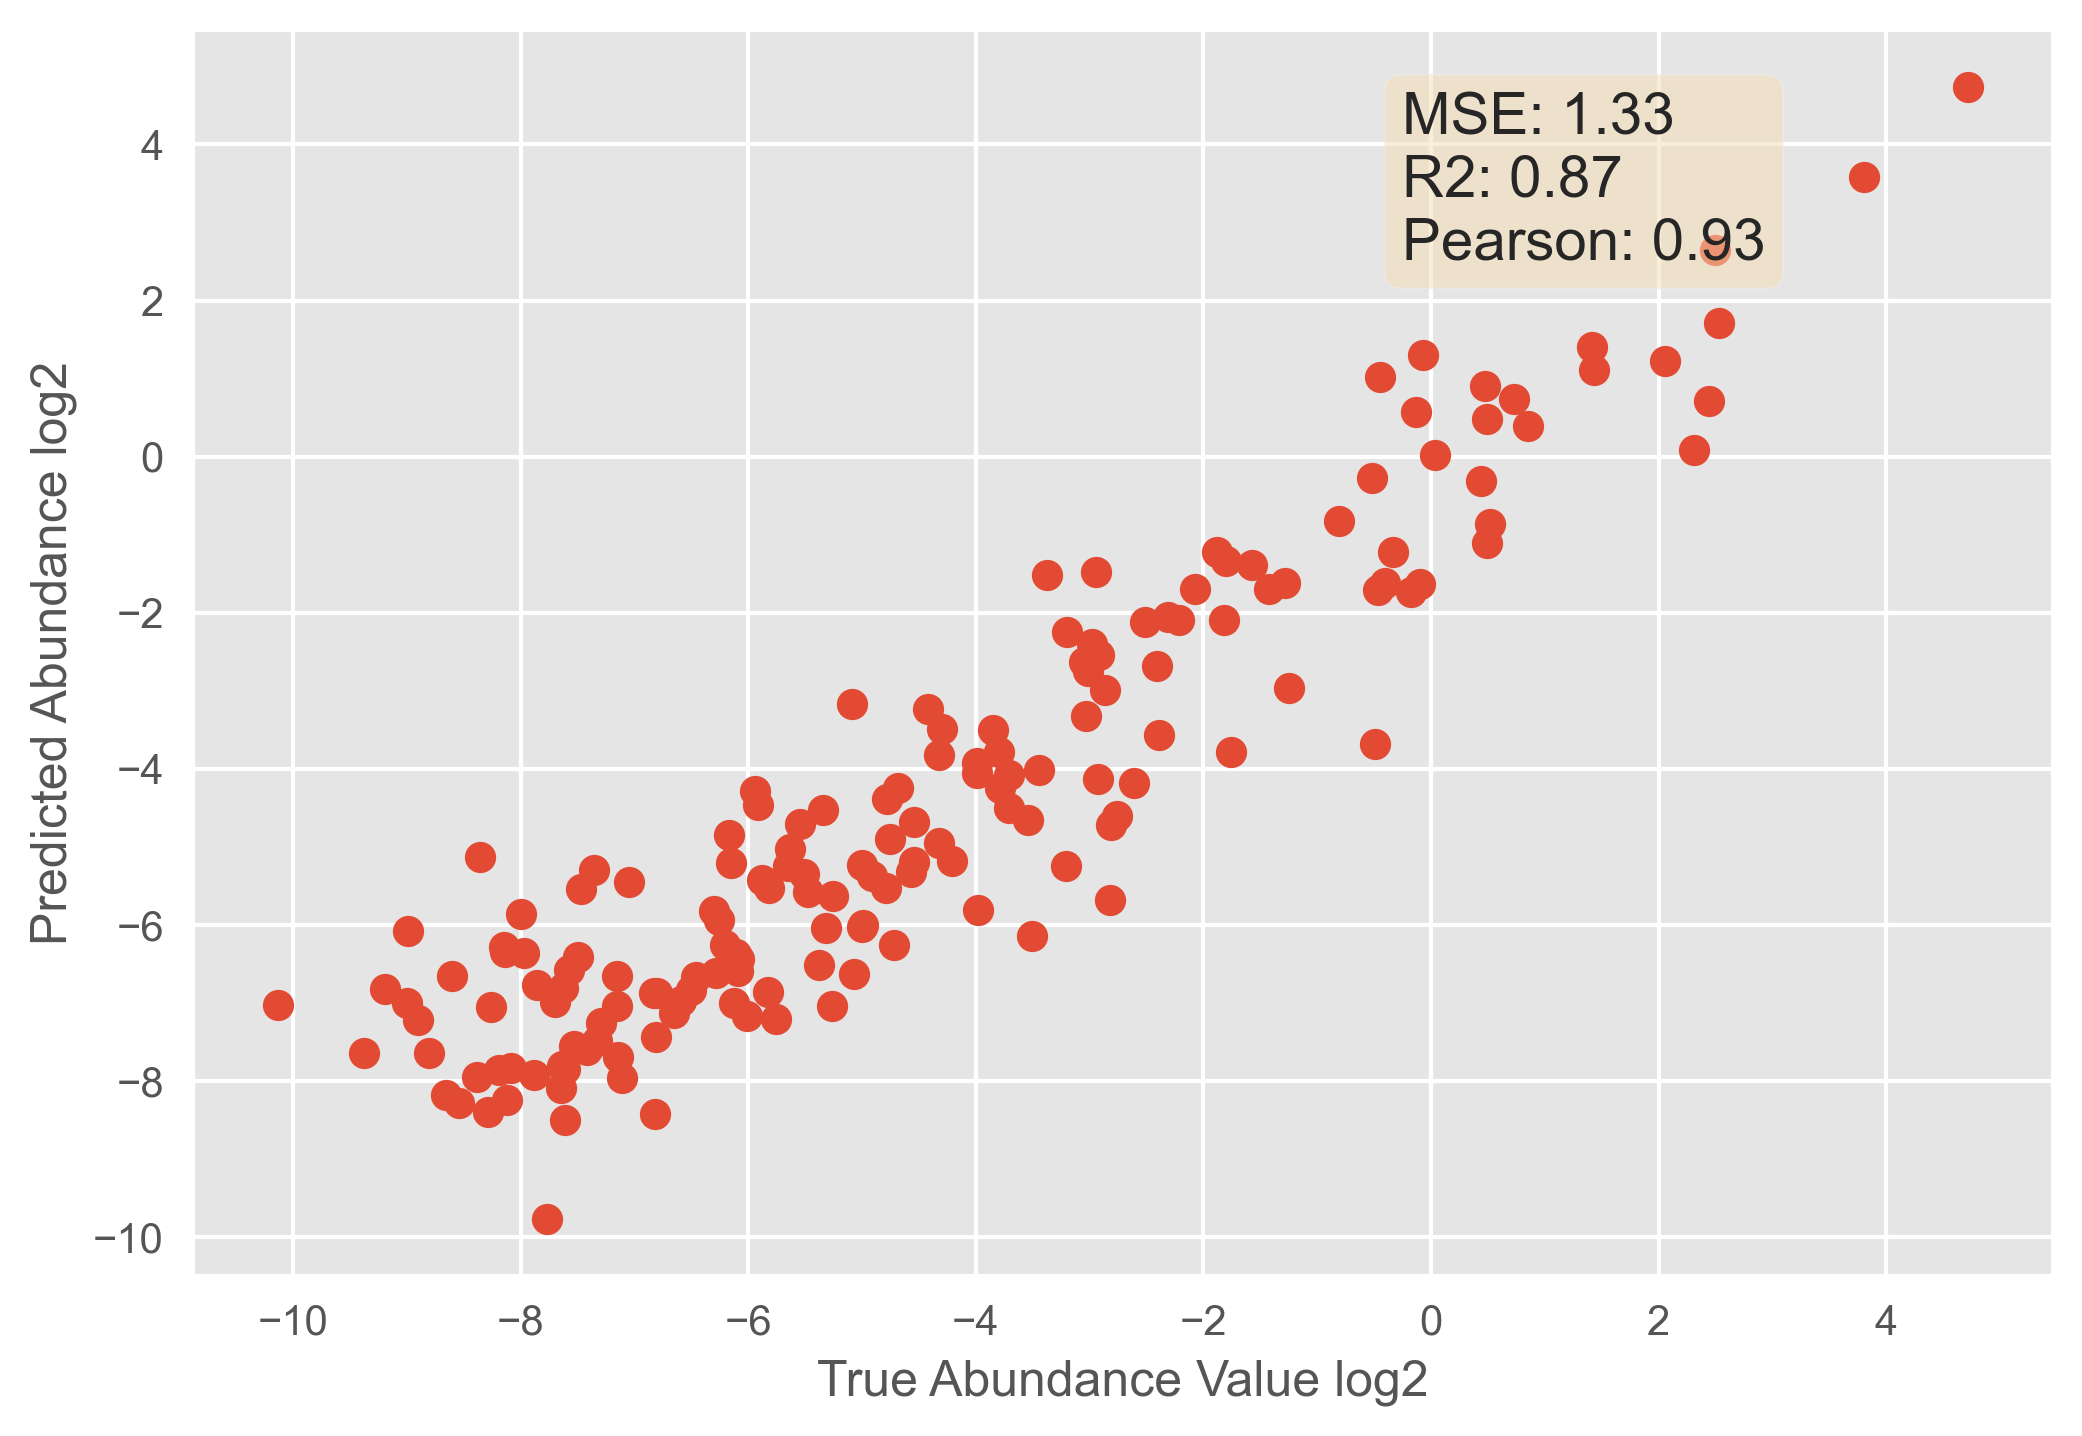

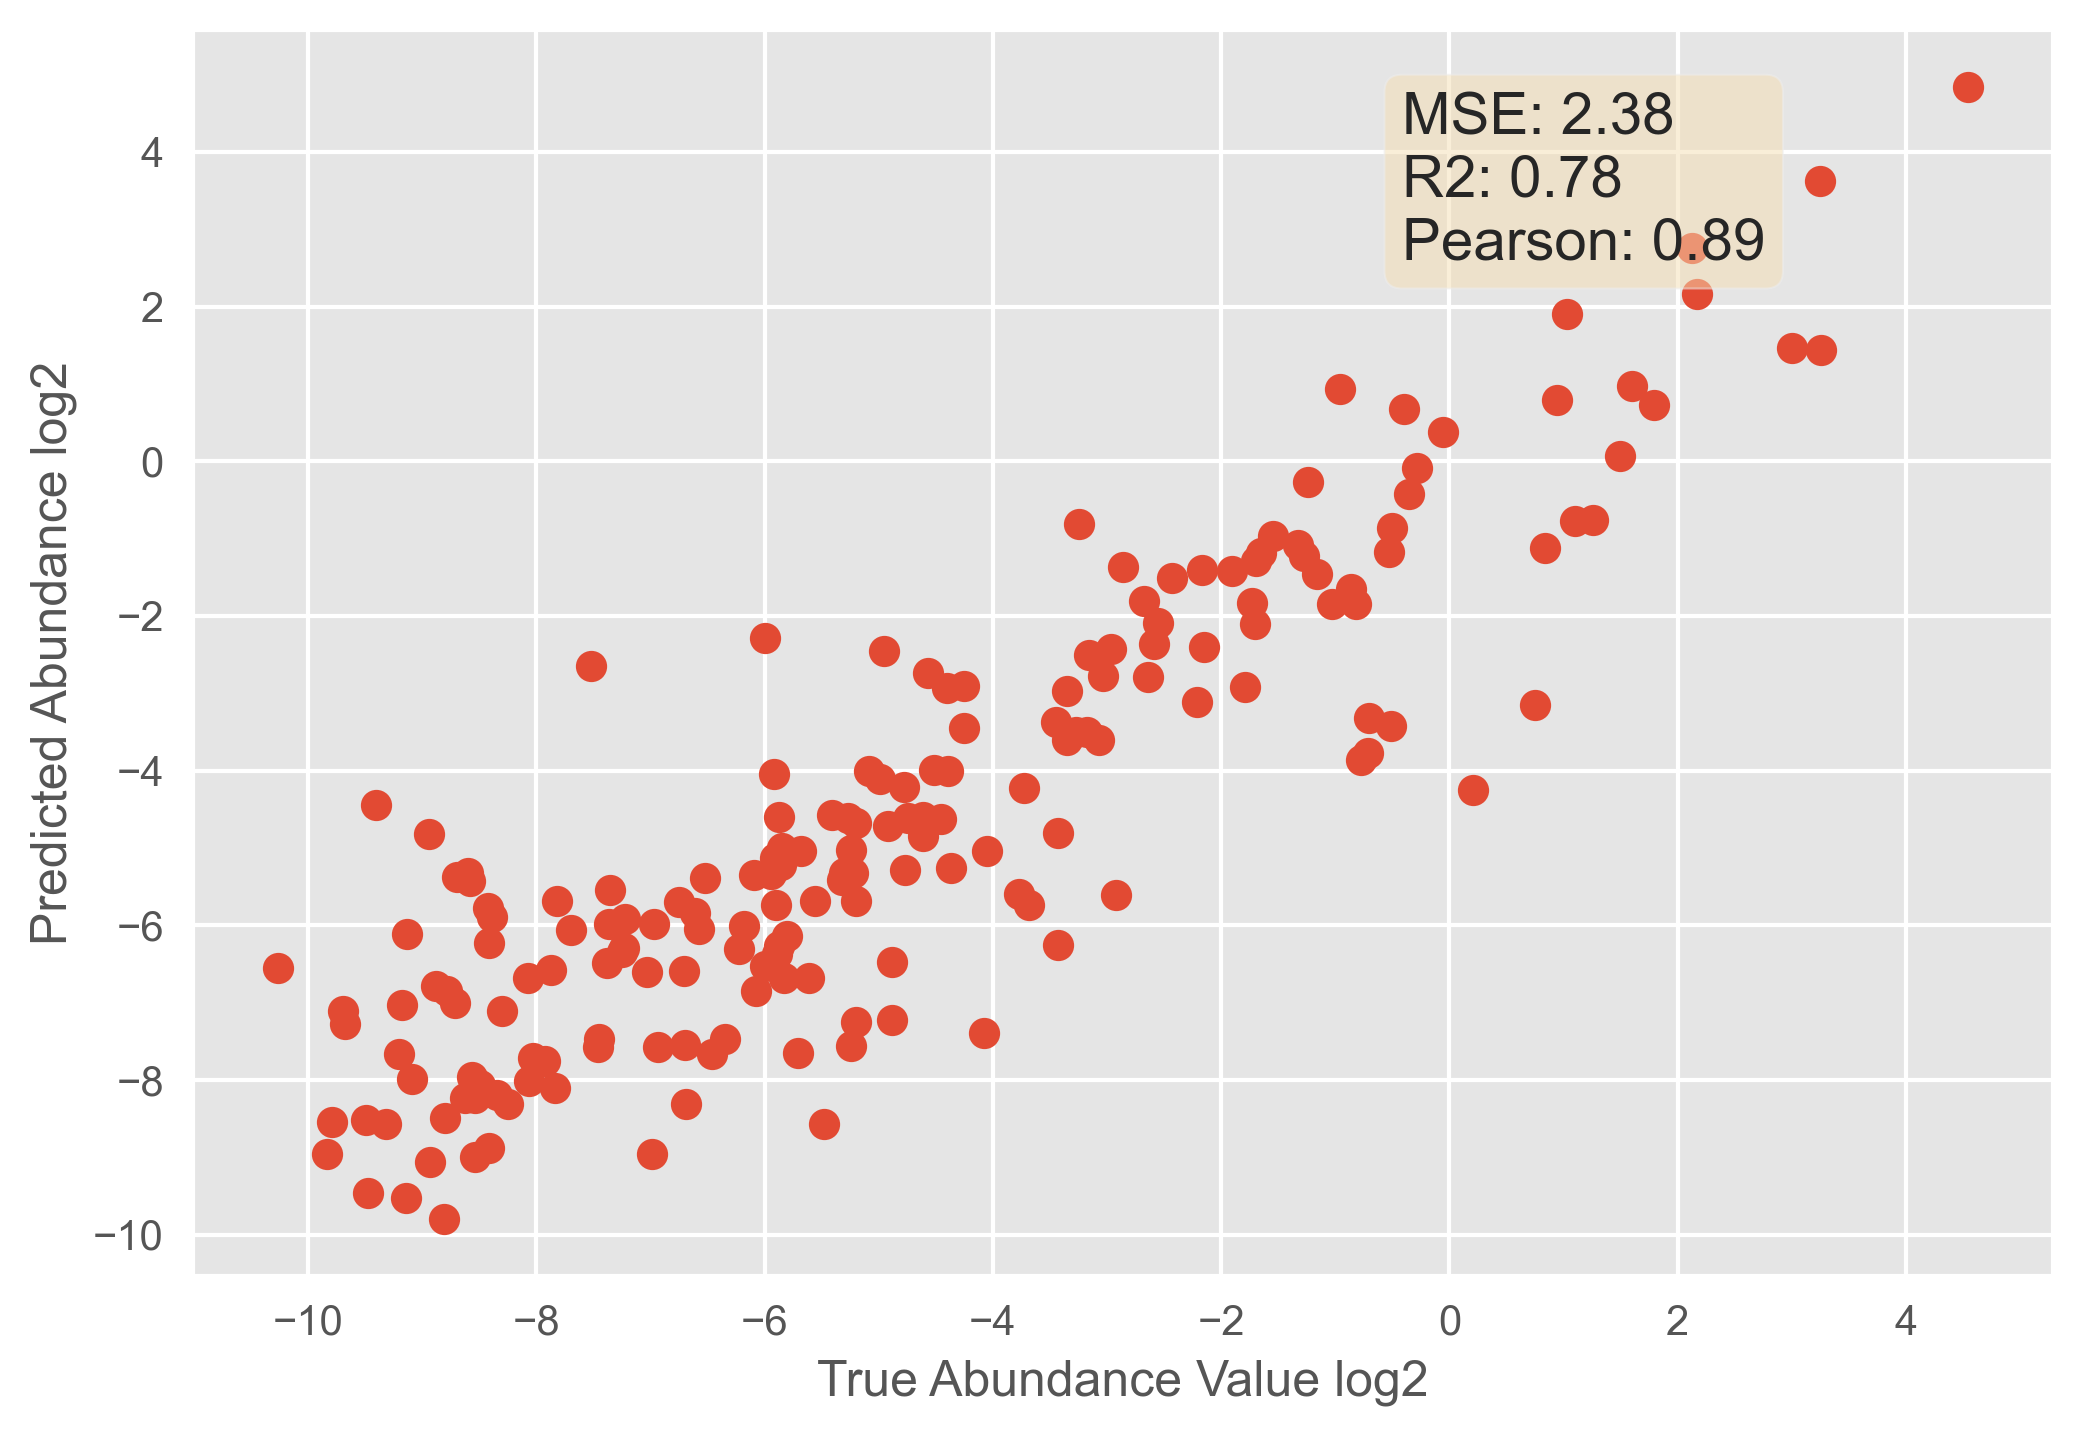

In [4]:
##Testing Each NP independently--RFR ## Which ones are hard to predict and which ones are easy?
#easy to hard NPUNID 1,20,19,16,7,31,34,34
df_filepath = 'Input_data/Save_files/df_2_Synth.xlsx'
df_a = pd.read_excel(df_filepath, header=0)
# labels= df_a['Abundance'].copy()
# id_col= df_a['NPUNID'].copy()
# label_abund=np.ravel(labels)

# NPUNID_list=[1,20,19,16,7,31,34,43,44]
NPUNID_list=df_a['NPUNID'].unique().tolist()
id_list=NPUNID_list
# Initialize a list to hold MSE scores for each removed ID
pearson_scores = []
r2_scores = []
mse = []


model=RandomForestRegressor(n_estimators=100)


eval_df = pd.DataFrame(columns=['Abundandce Filter', 'NPUNID', 'MSE', 'R2', 'Pearson'])
# for i in Abund_filter:
feat_list_RFR=['Abundance_Controls','Length','frac_aa_A','frac_aa_D','frac_aa_F','frac_aa_N','fraction_exposed_polar_total','rsa_std','fraction_exposed_exposed_C','fraction_exposed_exposed_E','fraction_exposed_exposed_H','nsp_secondary_structure_coil',	'nsp_secondary_structure_sheet','Zeta Potential','Dh_functionalized','NP_incubation Concentration (mg/mL)','Incubation Concentration (mg/ml)']

Min_Control=df_a['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
df_a= df_a[df_a['Abundance']>=Min_Control].copy()
results_df = pd.DataFrame()

# Loop through each ID in the list
for NPID in id_list:
    print(NPID)
    df=df_a.copy()
    # Remove the row with the current ID from the dataframe

    # Remove the row with the current ID from the dataframe
    removed_row = df.loc[df['NPUNID'] == NPID].copy()
    df = df.loc[df['NPUNID'] != NPID].copy()

    # Split the remaining data into features and target
    X_train = df[feat_list_RFR].copy()
    X_test = removed_row[feat_list_RFR].copy()
    y_train = np.ravel(df['Abundance'])
    y_train = np.log2(y_train)


    # Fit a random forest regression model to the training data
    model.fit(X_train, y_train)

    # Use the trained model to predict on the removed ID
    X_test = removed_row[X_train.columns]
    y_true = removed_row['Abundance']
    y_true= np.ravel(y_true)
    y_true= np.log2(y_true)
    y_pred = model.predict(X_test)
    # Calculate the Accuracy scores and add it to the list
    pearson, _ = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mse_score = mean_squared_error(y_true, y_pred)

    pearson_scores.append(pearson)
    r2_scores.append(r2)
    mse.append(mse_score)
    # plot the scatter plot
    fig, ax = plt.subplots()
    plt.style.use('ggplot')
    plt.rcParams['figure.dpi'] = 300
    ax.scatter(y_true, y_pred)
    ax.set_xlabel('True Abundance Value log2')
    ax.set_ylabel('Predicted Abundance log2')


    # add the metrics box to the plot
    box_text = f"MSE: {mse_score:.2f}\nR2: {r2:.2f}\nPearson: {pearson:.2f}"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.65, 0.95, box_text, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    plt.savefig('Output_data/NPtest_synth_' + str(NPID) + '.png', bbox_inches='tight')
    # print(id)
    tmp=pd.DataFrame({'Abundandce Filter': Min_Control,
                              'NPUNID':NPID,
                              'MSE':mse_score,
                              'R2':r2,
                              'Pearson':pearson},index=[0])
    eval_df = pd.concat([eval_df,tmp],ignore_index=True,axis=0)

    # create a DataFrame to store the current iteration's results
    current_df = pd.DataFrame({
        f"true_{NPID}": y_true,
        f"predict_{NPID}": y_pred
    })

    # append the current DataFrame to the results DataFrame
    results_df = pd.concat([results_df, current_df], axis=1)

# export the results DataFrame to a CSV file
results_df.to_csv("Output_data/NPID_InternalPrediction_results.xlsx", index=False)

eval_df.to_excel('Output_data/RFR_NPID_testing.xlsx', index=False)
# out=pd.DataFrame(list(zip(NPUNID_list,Abund_filter,pearson_scores,r2_scores,mse)), columns=['NPUNID','Abundance Filter','Pearson', 'R2', 'MSE'])
# out.to_excel('Output_data/PredictingEachNP_RFECV.xlsx',index=False)


In [ ]:
##External Validation--RFR## Which ones are hard to predict and which ones are easy?
#easy to hard NPUNID 1,20,19,16,7,31,34,34
df_filepath = 'Input_data/Save_files/df_2_Synth.xlsx'
df_a = pd.read_excel(df_filepath, header=0)
# labels= df_a['Abundance'].copy()
# id_col= df_a['NPUNID'].copy()
# label_abund=np.ravel(labels)

# NPUNID_list=[1,20,19,16,7,31,34,43,44]
prediction_filepath ='Input_data/Save_files/df_4_HS.xlsx'
df_pred = pd.read_excel(prediction_filepath, header=0)
NPUNID_list=df_pred['NPUNID'].unique().tolist()
id_list=NPUNID_list
# Initialize a list to hold MSE scores for each removed ID
pearson_scores = []
r2_scores = []
mse = []
model=RandomForestRegressor(n_estimators=100)
eval_df = pd.DataFrame(columns=['Abundandce Filter', 'NPUNID', 'MSE', 'R2', 'Pearson'])
# for i in Abund_filter:
feat_list_RFR=['Abundance_Controls','Length','frac_aa_A','frac_aa_D','frac_aa_F','frac_aa_N','fraction_exposed_polar_total','rsa_std','fraction_exposed_exposed_C','fraction_exposed_exposed_E','fraction_exposed_exposed_H','nsp_secondary_structure_coil',	'nsp_secondary_structure_sheet','Zeta Potential','Dh_functionalized','NP_incubation Concentration (mg/mL)','Incubation Concentration (mg/ml)']

Min_Control=df_a['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
df_a= df_a[df_a['Abundance']>=Min_Control].copy()
Min_Control=df_pred['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
df_pred= df_pred[df_pred['Abundance']>=Min_Control].copy()

for NPID in id_list:
    print(NPID)
    df_b=df_pred[df_pred['NPUNID']==NPID].copy()
    # Remove the row with the current ID from the dataframe

    # Split the remaining data into features and target
    X_train = df_a[feat_list_RFR].copy()
    X_test = df_b[feat_list_RFR].copy()
    y_train = np.ravel(df_a['Abundance'])
    y_train = np.log2(y_train)


    # Fit a random forest regression model to the training data
    model.fit(X_train, y_train)

    # Use the trained model to predict on the removed ID

    y_true = df_b['Abundance']
    y_true= np.ravel(y_true)
    y_true= np.log2(y_true)
    y_pred = model.predict(X_test)
    # Calculate the Accuracy scores and add it to the list
    pearson, _ = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mse_score = mean_squared_error(y_true, y_pred)

    pearson_scores.append(pearson)
    r2_scores.append(r2)
    mse.append(mse_score)
    # plot the scatter plot
    fig, ax = plt.subplots()
    plt.style.use('ggplot')
    plt.rcParams['figure.dpi'] = 300
    ax.scatter(y_true, y_pred)
    ax.set_xlabel('True Abundance Value log2')
    ax.set_ylabel('Predicted Abundance log2')


    # add the metrics box to the plot
    box_text = f"MSE: {mse_score:.2f}\nR2: {r2:.2f}\nPearson: {pearson:.2f}"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.65, 0.95, box_text, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    plt.savefig('Output_data/NPtest_HS_' + str(NPID) + '.png', bbox_inches='tight')
    # print(id)
    tmp=pd.DataFrame({'Abundandce Filter': Min_Control,
                              'NPUNID':NPID,
                              'MSE':mse_score,
                              'R2':r2,
                              'Pearson':pearson},index=[0])
    eval_df = pd.concat([eval_df,tmp],ignore_index=True,axis=0)

eval_df.to_excel('Output_data/PredictingHS_Samples.xlsx', index=False)
# out=pd.DataFrame(list(zip(NPUNID_list,Abund_filter,pearson_scores,r2_scores,mse)), columns=['NPUNID','Abundance Filter','Pearson', 'R2', 'MSE'])
# out.to_excel('Output_data/PredictingEachNP_RFECV.xlsx',index=False)

In [51]:
##External Validation--RFC## Which ones are hard to predict and which ones are easy?
#easy to hard NPUNID 1,20,19,16,7,31,34,34
df_filepath = 'Input_data/Save_files/df_2_Synth.xlsx'
df_a = pd.read_excel(df_filepath, header=0)
# labels= df_a['Abundance'].copy()
# id_col= df_a['NPUNID'].copy()
# label_abund=np.ravel(labels)

# NPUNID_list=[2,16,7,8,9,10,11,12]
prediction_filepath ='Input_data/Save_files/df_4_HS.xlsx'
df_pred = pd.read_excel(prediction_filepath, header=0)
model=RandomForestClassifier()


Min_Abund=df_a['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
df_a['Abundance_Controls'].replace(0,Min_Abund,inplace=True)
df_a['Enrich']= np.log2(df_a['Abundance']/df_a['Abundance_Controls'])
df_a['binary_target']= df_a['Enrich'].apply(lambda t: 1 if t>=thresh else 0)
labels_df = df_a['binary_target'].copy()
label_abund=np.ravel(labels_df)


NPUNID_list=df_pred['NPUNID'].unique().tolist()
id_list=NPUNID_list
# Initialize a list to hold MSE scores for each removed ID
# f1 = []
# auroc = []
# accuracy = []
model=RandomForestClassifier(n_estimators=100)
eval_df = pd.DataFrame(columns=['NPUNID', 'f1', 'AUROC', 'Accuracy','precision','recall'])
# for i in Abund_filter:
feat_list_RFR=['Zeta Potential','Dh_functionalized','secondary_structure_fraction_sheet','Surface_Ligand','fraction_buried','Dtem','isoelectric_point','frac_aa_R','fraction_exposed_exposed_P','Incubation Concentration (mg/ml)','fraction_exposed_exposed_K','frac_aa_C','frac_aa_I','frac_aa_A','flexibility_min','molecular_weight']

for NPID in id_list:
    print(NPID)
    df_b=df_pred[df_pred['NPUNID']==NPID].copy()
    Min_Abund=df_pred['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    df_b['Abundance_Controls'].replace(0,Min_Abund,inplace=True)
    df_b['Enrich']= np.log2(df_b['Abundance']/df_b['Abundance_Controls'])
    df_b['binary_target']= df_b['Enrich'].apply(lambda t: 1 if t>=thresh else 0)
    labels_df = df_b['binary_target'].copy()
    label_target=np.ravel(labels_df)

    # Split the remaining data into features and target
    X_train = df_a[feat_list_RFR].copy()
    X_test = df_b[feat_list_RFR].copy()
    y_train = label_abund


    # Fit a random forest regression model to the training data
    model.fit(X_train, y_train)

    # Use the trained model to predict on the removed ID

    y_true = label_target
    y_pred = model.predict(X_test)
    # Calculate the Accuracy scores and add it to the list
    f1 = f1_score(y_true, y_pred)
    auroc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)


    # print(id)
    tmp=pd.DataFrame({'NPUNID':NPID,'f1':f1,'AUROC':auroc,'Accuracy':accuracy,'precision':precision,'recall':recall},index=[0])
    eval_df = pd.concat([eval_df,tmp],ignore_index=True,axis=0)

eval_df.to_excel('Output_data/Predicting_HS_Samples_RFC.xlsx', index=False)
# out=pd.DataFrame(list(zip(NPUNID_list,Abund_filter,pearson_scores,r2_scores,mse)), columns=['NPUNID','Abundance Filter','Pearson', 'R2', 'MSE'])
# out.to_excel('Output_data/PredictingEachNP_RFECV.xlsx',index=False)

C:\Users\pouls\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\pouls\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


54
51


C:\Users\pouls\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


52


C:\Users\pouls\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


57


C:\Users\pouls\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


53


C:\Users\pouls\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


56


C:\Users\pouls\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


55


C:\Users\pouls\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [47]:
y_pred

array([0.46      , 0.61      , 0.53      , 0.04      , 0.1       ,
       0.77      , 0.02      , 0.99      , 0.02      , 1.        ,
       0.02      , 0.03      , 0.98      , 0.24      , 0.9       ,
       0.21      , 0.26      , 0.        , 0.92      , 0.97      ,
       0.53      , 0.05      , 0.21      , 0.94      , 0.09      ,
       0.63      , 0.25666667, 0.8       , 0.95      , 0.        ,
       0.06      , 0.02      , 0.62      , 0.73      , 0.31      ,
       0.04      , 0.42      , 0.91      , 0.01      , 0.42      ,
       0.58      , 0.12      , 0.        , 0.        , 0.07      ,
       0.13      , 0.45      , 0.16      , 0.        , 0.15      ,
       0.        , 0.38      , 0.01      , 0.27      , 0.        ,
       0.95      , 0.91      , 0.28      , 0.06      , 0.7       ,
       0.045     , 0.65      , 0.03      , 0.91      , 0.        ,
       0.77      , 0.08      , 0.        , 0.13      , 0.23      ,
       0.91      , 0.94      , 0.05      , 0.33      , 0.1    

In [ ]:
##External Validation on RFC Methods#
##External Validation--RFR## Which ones are hard to predict and which ones are easy?
df_filepath = 'Input_data/Save_files/df_2_Synth.xlsx'
df_a = pd.read_excel(df_filepath, header=0)


NPUNID_list=[2,16,7,8,9,10,11,12]
prediction_filepath ='Input_data/Save_files/df_1_all.xlsx'
df_pred = pd.read_excel(prediction_filepath, header=0)

id_list=NPUNID_list
# Initialize a list to hold MSE scores for each removed ID
pearson_scores = []
r2_scores = []
mse = []
model=RandomForestClassifier(n_estimators=100)
eval_df = pd.DataFrame(columns=['Abundandce Filter', 'NPUNID', 'MSE', 'R2', 'Pearson'])
# for i in Abund_filter:
feat_list_RFR=['Abundance_Controls','Length','frac_aa_A','frac_aa_D','frac_aa_F','frac_aa_N','fraction_exposed_polar_total','rsa_std','fraction_exposed_exposed_C','fraction_exposed_exposed_E','fraction_exposed_exposed_H','nsp_secondary_structure_coil',	'nsp_secondary_structure_sheet','Zeta Potential','Dh_functionalized','NP_incubation Concentration (mg/mL)','Incubation Concentration (mg/ml)']

Min_Control=df_a['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
df_a= df_a[df_a['Abundance']>=Min_Control].copy()
Min_Control=df_pred['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
df_pred= df_pred[df_pred['Abundance']>=Min_Control].copy()

for NPID in id_list:
    print(NPID)
    df_b=df_pred[df_pred['NPUNID']==NPID].copy()
    # Remove the row with the current ID from the dataframe

    # Split the remaining data into features and target
    X_train = df_a[feat_list_RFR].copy()
    X_test = df_b[feat_list_RFR].copy()
    y_train = np.ravel(df_a['Abundance'])
    y_train = np.log2(y_train)


    # Fit a random forest regression model to the training data
    model.fit(X_train, y_train)

    # Use the trained model to predict on the removed ID

    y_true = df_b['Abundance']
    y_true= np.ravel(y_true)
    y_true= np.log2(y_true)
    y_pred = model.predict(X_test)
    # Calculate the Accuracy scores and add it to the list
    pearson, _ = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mse_score = mean_squared_error(y_true, y_pred)

    pearson_scores.append(pearson)
    r2_scores.append(r2)
    mse.append(mse_score)
    # plot the scatter plot
    fig, ax = plt.subplots()
    plt.style.use('ggplot')
    plt.rcParams['figure.dpi'] = 300
    ax.scatter(y_true, y_pred)
    ax.set_xlabel('True Abundance Value log2')
    ax.set_ylabel('Predicted Abundance log2')


    # add the metrics box to the plot
    box_text = f"MSE: {mse_score:.2f}\nR2: {r2:.2f}\nPearson: {pearson:.2f}"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.65, 0.95, box_text, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    plt.savefig('Output_data/NPtest_HS_' + str(NPID) + '.png', bbox_inches='tight')
    # print(id)
    tmp=pd.DataFrame({'Abundandce Filter': Min_Control,
                              'NPUNID':NPID,
                              'MSE':mse_score,
                              'R2':r2,
                              'Pearson':pearson},index=[0])
    eval_df = pd.concat([eval_df,tmp],ignore_index=True,axis=0)

eval_df.to_excel('Output_data/PredictingBALF_FBS_Samples.xlsx', index=False)

In [17]:
##Run Quality Control on df to get a look at important features and such##
df_filepath = 'Input_data/Save_files/df_1_all_RFE50_RFR.xlsx'
df_a = pd.read_excel(df_filepath, header=0)
labels= df_a['Abundance'].copy()
id_col= df_a['NPUNID'].copy()
label_abund=np.ravel(labels)


# Initialize a list to hold MSE scores for each removed ID
model=RandomForestRegressor(n_estimators=100)
df_a=df_a.drop(columns=['Abundance','NPUNID'],axis=1).copy()
df_a=RFECV_plot(df_a,label_abund,model,'b',folds=5,step=2)
scram_score(df, label_abund, model, id, 0.2)
feat_drop(df, label_abund, model, id, 0.2)
# feat_drop_multifold(df, label_abund, model, id, 0.2, folds=splits)
tmp2=scorer(df, label_abund, model, id, 10)
zeros=(raw_MS_data['Abundance']==0).sum()
percent_zeros=zeros/raw_MS_data.shape[0]
tmp2['TotalZeros']=zeros
tmp2['Percent_zeros']=percent_zeros
summary_tmp.append(tmp2)
# lasso_feature_selection(df, label_abund, id)
summary=pd.concat(summary_tmp,axis=0)

Recursive Feature Elimination with Correlated Features ran successfully


NameError: name 'df' is not defined

In [ ]:
###Run Histogram of each Feature###
# Get total number of rows
df=df_a
total_count = len(df)
df = df.rename(columns=lambda x: x.replace('/', ''))
# Loop over each column of the dataframe
for col in df.columns:
    # Create a histogram of the current column, with bins=10
    data=df[col]
    plt.hist(data, weights=np.ones_like(data) / len(data))

    # Set the title of the histogram to the column name and percent of total population
    plt.title(str(col))
    plt.savefig('Output_data/{}.png'.format(str(col)))
    plt.close()
    # Show the histogram
    # plt.show()
